# Trabajo Práctico N2 | Predicción de Lluvia en Australia

## Integrantes
- Esteva Matias (E-1253/1)
- Prieto Tobias (P-5260/4)


## Librerías

In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from geopy.geocoders import Nominatim
from sklearn.metrics import classification_report,make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import time
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
import re
import joblib
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import loguniform
# from pycaret.classification import *

In [124]:
!gdown 1fHy-yvyeXu90qSHgYGQb9_q8vtGIRNyX
!gdown 1dUieXeKJNhwSPRjhfe0NuIUJrXY_uJS5

Downloading...
From: https://drive.google.com/uc?id=1fHy-yvyeXu90qSHgYGQb9_q8vtGIRNyX
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 57.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dUieXeKJNhwSPRjhfe0NuIUJrXY_uJS5
To: /content/coordenadas_aus.csv
100% 1.71k/1.71k [00:00<00:00, 7.33MB/s]


## Carga del dataset

In [125]:
df = pd.read_csv('weatherAUS.csv')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [127]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

### Creación de CSV para las coordenadas de los lugares
Las siguientes 2 celdas buscan las coordenadas para las ciudades y para los lugares que no son ciudades (estaciones meteorológicas, aeropuertos)


In [128]:
def obtener_coordenadas(df):
  lugares = df['Location'].value_counts().index
  geolocator = Nominatim(user_agent="geo_aus")
  coords = []

  for ciudad in lugares:
     location = geolocator.geocode(ciudad + ", Australia")
     if location:
         coords.append({
             "Location": ciudad,
             "Latitud": location.latitude,
             "Longitud": location.longitude
         })
     time.sleep(1)

  df_coords = pd.DataFrame(coords)

  no_ciudades = [item for item in lugares if item not in df_coords['Location'].values]

  def normalizar_nombre(nombre):
      # Inserta espacio entre minúscula y mayúscula
      nombre = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', nombre)
      # Corrige abreviaciones comunes
      reemplazos = {
          "RAAF": "RAAF Base",
          "Airport": "Airport",
          "Island": "Island",
          "Creek": "Creek",
      }
      for k, v in reemplazos.items():
          nombre = nombre.replace(k, v)
      return nombre.strip()

  def buscar_geocode(nombre):
      variantes = []
      nombre_limpio = normalizar_nombre(nombre)
      variantes.append(f"{nombre_limpio}, Australia")

      # Si contiene 'Airport', probamos también agregando la ciudad y 'Airport'
      if "Airport" in nombre_limpio:
          variantes.append(nombre_limpio.replace("Airport", " Airport, Australia"))

      # Si contiene 'RAAF', probamos 'RAAF Base'
      if "RAAF" in nombre_limpio:
          variantes.append(nombre_limpio.replace("RAAF", "RAAF Base") + ", Australia")

      # Si contiene 'Mount', probamos con 'Mt'
      if "Mount" in nombre_limpio:
          variantes.append(nombre_limpio.replace("Mount", "Mt") + ", Australia")

      # Búsqueda por variantes
      for query in variantes:
          try:
              location = geolocator.geocode(query)
              if location:
                  return location.latitude, location.longitude
          except Exception:
              return None, None
      return None, None, None

  # Buscar coordenadas
  resultados = []
  for lugar in no_ciudades:
      lat, lon = buscar_geocode(lugar)
      resultados.append({"Location": lugar, "Latitud": lat, "Longitud": lon})
      time.sleep(1.2)

  df_coords2 = pd.DataFrame(resultados)


  # Guarda en un CSV todas las ubicaciones con sus coordenadas para no tener que ejecutar cada vez las 2 celdas de arriba que llevan bastante tiempo
  df_coordenadas = pd.concat([df_coords, df_coords2], ignore_index=True)
  df_coordenadas.to_csv("coordenadas_aus.csv", index=False, encoding="utf-8-sig")



#obtener_coordenadas(df)

### Lectura del csv para las coordenadas de los lugares

In [129]:
df_coordenadas = pd.read_csv("coordenadas_aus.csv")

In [130]:
# Unir al dataset original las coordenadas de cada ubicacion
df = df.merge(df_coordenadas, on="Location", how="left")

# Análisis descriptivo y visualización de datos


Para comenzar con nuestro análisis debemos comprender cómo son y cómo se comportan nuestras variables, por lo que a continuación haremos un listado con cada una de ellas:
- Date: La fecha del registro.
- Location: La localidad donde se registró.
- MinTemp: La temperatura mínima registrada ese día (expresada en Celsius).
- MaxTemp: La temperatura máxima registrada ese día (expresada en Celsius).
- Rainfall: Expresa los milímetros de lluvia acumulada.
- Evaporation: Expresa cuánta agua se evaporó en esa cuenca de referencia (milímetros).
- Sunshine: Horas de sol brillante durante ese día (horas).
- WindGustDir: Dirección del viento más fuerte registrado en el día.
- WindGustSpeed: Expresa la velocidad de la rafaga de viento más fuerte (km/h).
- WindDir9am: Dirección del viento a las 9am.
- WindDir3pm: Dirección del viento a las 3pm.
- WindSpeed9am: Velocidad del viento promedio poco antes de las 9am (km/h).
- WindSpeed3pm: Velocidad del viento promedio poco antes de las 3pm (km/h).
- Humidity9am: Humedad relativa a las 9am (porcentaje).
- Humidity3pm: Humedad relativa a las 3pm (porcentaje).
- Pressure9am: Presión atmosférica ajustada a nivel del mar a las 9am (hPa).
- Pressure9am: Presión atmosférica ajustada a nivel del mar a las 3pm (hPa).
- Cloud9am: Fracción del cielo cubierto por nubes a las 9am. Se mide en “octas” (0 = cielo claro, 8 = completamente cubierto).
- Cloud3pm: Fracción del cielo cubierto por nubes a las 3pm. Se mide en “octas” (0 = cielo claro, 8 = completamente cubierto).
- Temp9am: Temperatura observada a las 9am (Celsius).
- Temp3pm: Temperatura observada a las 3pm (Celsius).
- RainToday: Indica si el día actual tuvo lluvia.
- RainTomorrow: Variable objetivo, indica si al día siguiente llovió.





In [131]:
# Convertimos a tipo datetime la columna Date
df['Date']=pd.to_datetime(df['Date'])

In [132]:
# Decidimos eliminar los registros que le falten mas del 70% de los datos (456 datos)
num_nulos_por_fila = df.isnull().sum(axis=1)
porcentaje_nulos = num_nulos_por_fila / len(df.columns)
filas_con_nulos_70_porciento = df[porcentaje_nulos >= 0.7]
df.drop(index=filas_con_nulos_70_porciento.index, inplace=True)

In [133]:
df.describe()

Date        MinTemp        MaxTemp  \
count                         145111  143966.000000  144165.000000   
mean   2013-04-05 21:33:05.010095616      12.194206      23.222244   
min              2007-11-01 00:00:00      -8.500000      -4.800000   
25%              2011-01-13 00:00:00       7.600000      17.900000   
50%              2013-06-03 00:00:00      12.000000      22.600000   
75%              2015-06-15 00:00:00      16.900000      28.200000   
max              2017-06-25 00:00:00      33.900000      48.100000   
std                              NaN       6.398462       7.118068   

            Rainfall   Evaporation      Sunshine  WindGustSpeed  \
count  142147.000000  82605.000000  75561.000000  135194.000000   
mean        2.360721      5.467525      7.609223      40.035475   
min         0.000000      0.000000      0.000000       6.000000   
25%         0.000000      2.600000      4.800000      31.000000   
50%         0.000000      4.800000      8.400000      39.000000   
75%         0.800000      7.400000     10.600000      48.000000   
max       371.000000    145.000000     14.500000     135.000000   
std         8.477784      4.194723      3.785220      13.607053   

        WindSpeed9am   WindSpeed3pm    Humidity9am    Humidity3pm  \
count  143693.000000  142396.000000  142806.000000  140949.000000   
mean       14.043426      18.662673      68.880831      51.538656   
min         0.000000       0.000000       0.000000       0.000000   
25%         7.000000      13.000000      57.000000      37.000000   
50%        13.000000      19.000000      70.000000      52.000000   
75%        19.000000      24.000000      83.000000      66.000000   
max       130.000000      87.000000     100.000000     100.000000   
std         8.915375       8.809827      19.029164      20.795990   

         Pressure9am    Pressure3pm      Cloud9am      Cloud3pm  \
count  130390.000000  130427.000000  89571.000000  86101.000000   
mean     1017.650205    1015.256155      4.447500      4.509971   
min       980.500000     977.100000      0.000000      0.000000   
25%      1012.900000    1010.400000      1.000000      2.000000   
50%      1017.600000    1015.200000      5.000000      5.000000   
75%      1022.400000    1020.000000      7.000000      7.000000   
max      1041.000000    1039.600000      9.000000      9.000000   
std         7.106486       7.037364      2.887152      2.720347   

             Temp9am        Temp3pm        Latitud       Longitud  
count  143693.000000  141847.000000  145111.000000  145111.000000  
mean       16.990631      21.683448     -32.859326     141.955983  
min        -7.200000      -5.400000     -42.882509     115.100477  
25%        12.300000      16.600000     -36.759018     138.599931  
50%        16.700000      21.100000     -34.026335     145.304505  
75%        21.600000      26.400000     -31.673960     150.694171  
max        40.200000      46.700000     -12.460440     167.948314  
std         6.488753       6.936582       6.039784      12.035190

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145111 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145111 non-null  datetime64[ns]
 1   Location       145111 non-null  object        
 2   MinTemp        143966 non-null  float64       
 3   MaxTemp        144165 non-null  float64       
 4   Rainfall       142147 non-null  float64       
 5   Evaporation    82605 non-null   float64       
 6   Sunshine       75561 non-null   float64       
 7   WindGustDir    135132 non-null  object        
 8   WindGustSpeed  135194 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141230 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142396 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140949 non-null  float64       
 15  Press

### Visualización de variables

#### Variables categóricas

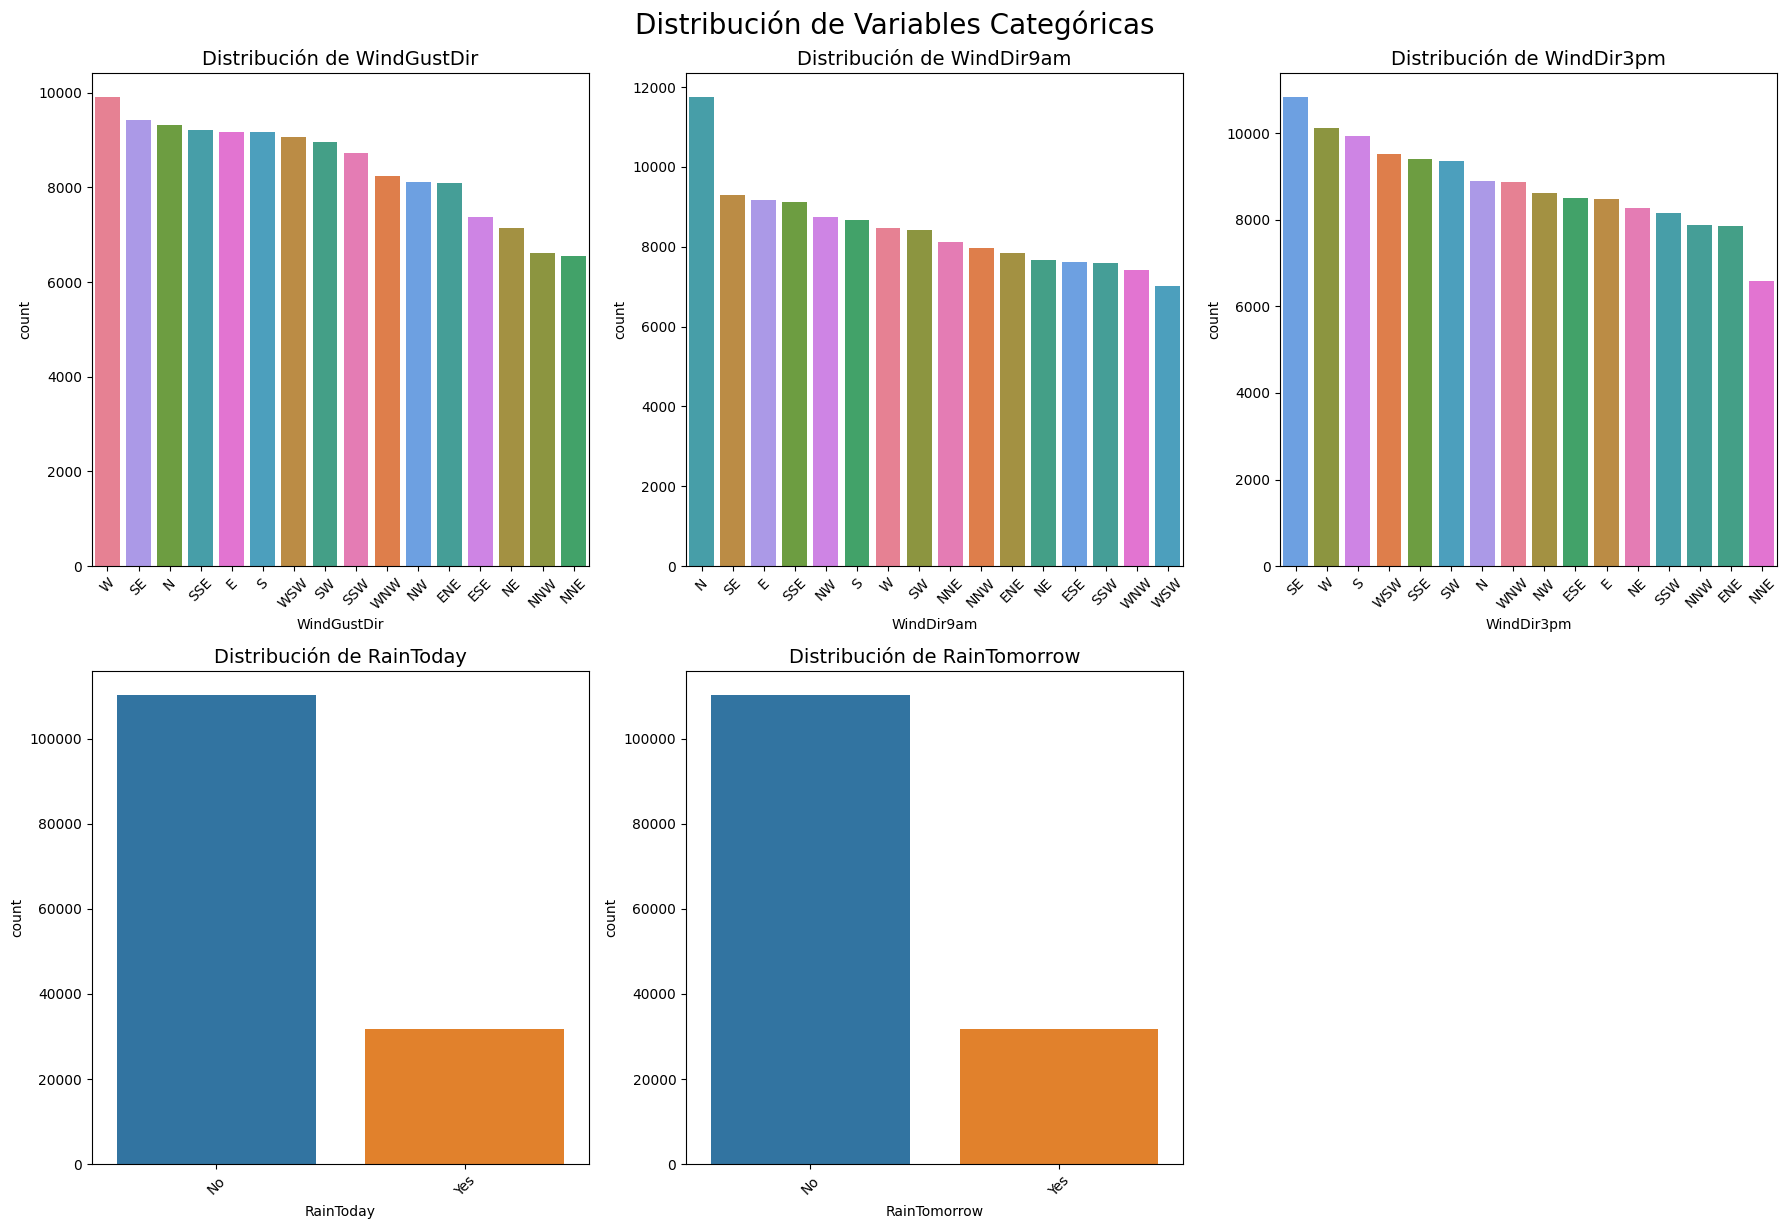

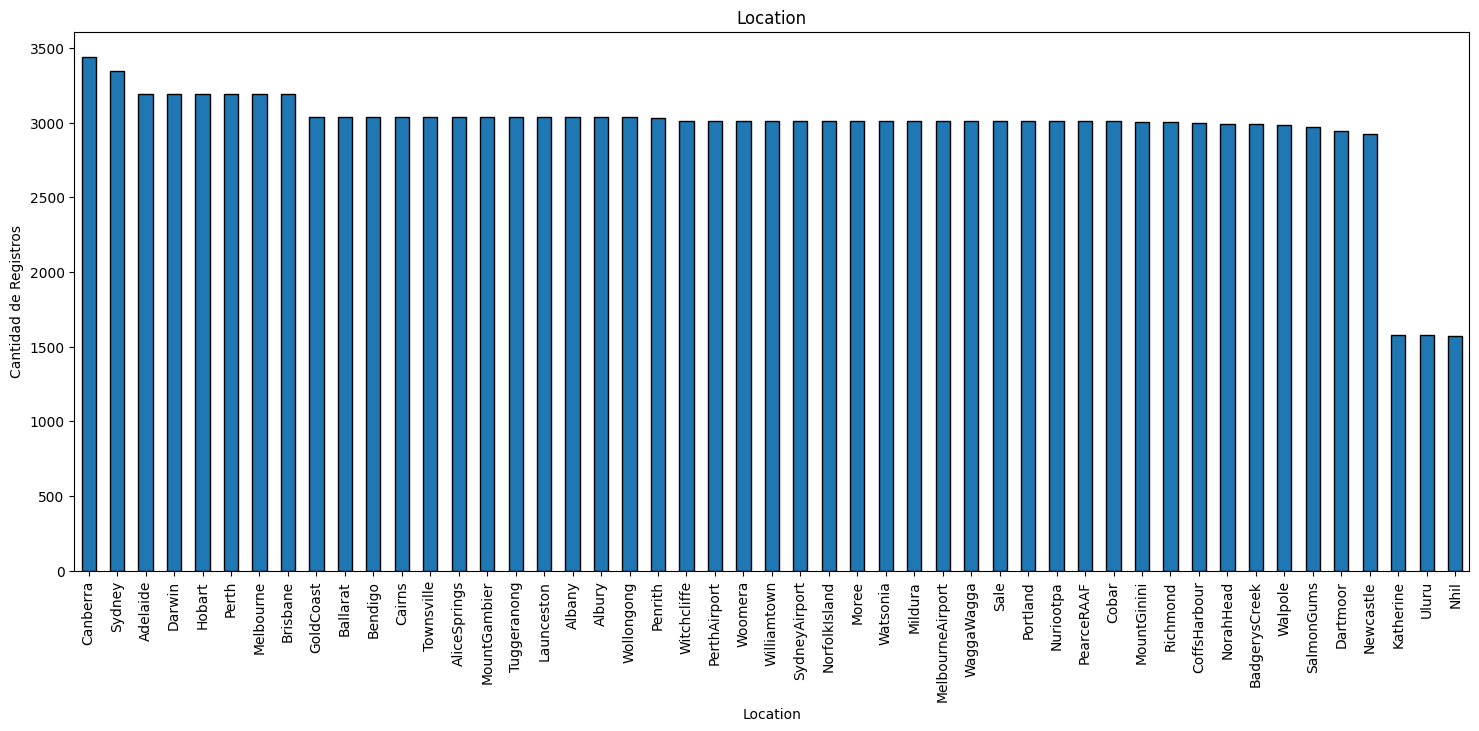

In [135]:
cols_categoricas = [
    'Location', 'WindGustDir', 'WindDir9am',
    'WindDir3pm', 'RainToday', 'RainTomorrow'
]

cols_categoricas_to_plot = [
    'WindGustDir', 'WindDir9am', 'WindDir3pm',
    'RainToday', 'RainTomorrow'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for col, ax in zip(cols_categoricas_to_plot, axes.flatten()):
    sns.countplot(
        data=df,
        x=col,
        ax=ax,
        order=df[col].value_counts().index,
        hue=col,
        legend=False
    )

    ax.set_title(f'Distribución de {col}', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.suptitle("Distribución de Variables Categóricas", y=1.02, fontsize=20)
plt.show()




plt.figure(figsize=(18, 7))
df['Location'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Location')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=90)
plt.show()



Observando las distribuciones de las variables categóricas podemos ver como existen una gran cantidad de localizaciones en donde se tomaron registros para este dataset, en la mayoría de ellas cuentan con una cantidad de observaciones similares a excepción de 'Katherine', 'Uluru' y 'Nhil' que cuentan aproximadamente con la mitad de registros en comparación al resto.


En cuanto a las variables 'RainToday' y 'RainTomorrow' notamos que presentan una distribución casi idéntica, lo que a priori nos podría indicar que muchos de los días que presentaron lluvias, se extendieron al dia siguiente, ademas de que está fuertemente desbalanceada la proporción de casos en donde hay y no precipitaciones.


Si miramos las direcciones de los vientos vemos que la mayoría cuentan con registros provenientes del Oeste, Norte y del Sureste.


#### Variables numéricas

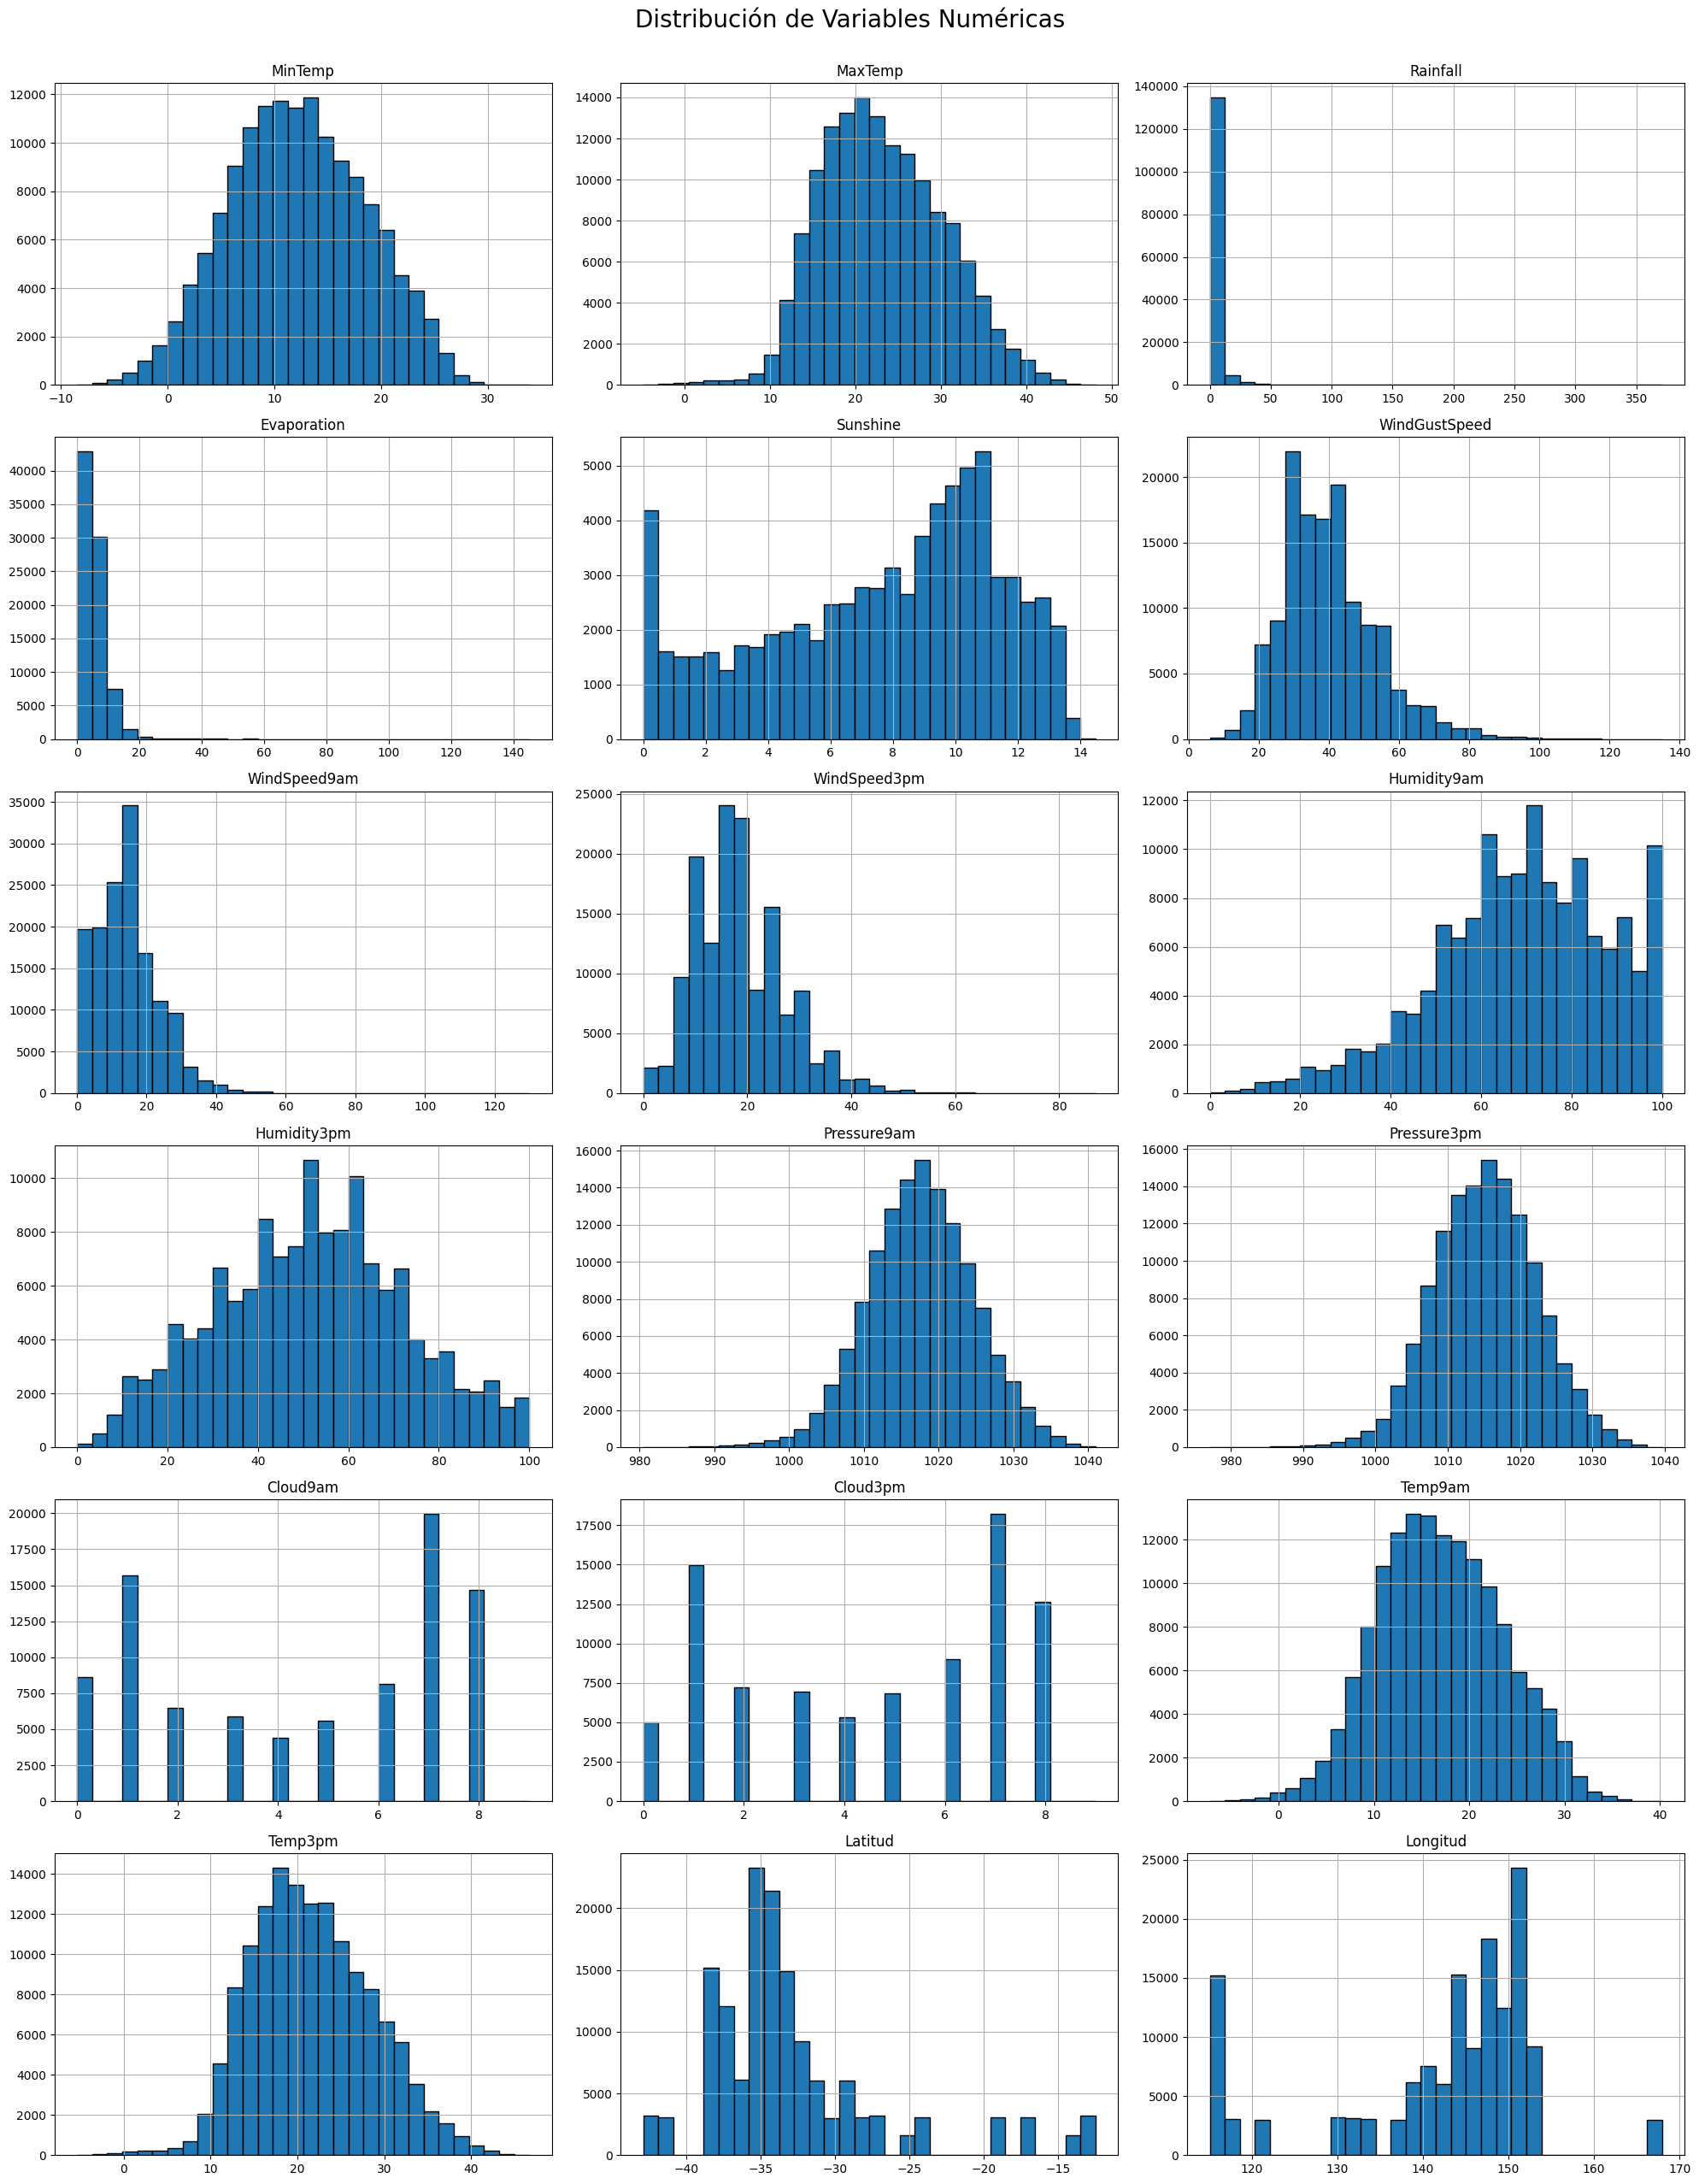

In [136]:
cols_numericas = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
    'Cloud3pm', 'Temp9am', 'Temp3pm', 'Latitud', 'Longitud'
]

fig = df[cols_numericas].hist(bins=30, figsize=(20, 25), layout=(6, 3), edgecolor='black')

# Ajustar el layout para que los títulos y etiquetas no se superpongan
plt.tight_layout()
plt.suptitle("Distribución de Variables Numéricas", y=1.02, fontsize=20)
plt.show()


En cuanto a las distribuciones de las variables numéricas, podemos ver similitudes entre algunas de ellas, por ejemplo las relacionadas a las temperatura se distribuyen en gran parte de manera normal.


Luego otras presentan asimetrías marcadas hacia la derecha como puede ser el caso de 'Evaporation', 'Rainfall', y las que detallan las velocidades de los vientos.


Por el contrario, variables como las encargadas de medir las presiones y la humedad presentan distribuciones normales levemente marcadas hacia la izquierda.


Por último el caso de variables más particulares como lo son las que miden la nubosidad que van de valores enteros del 0 al 8, o las longitudes y latitudes que expresan una ubicación en el globo.En relación con las distribuciones de las variables numéricas, se observan varias tendencias.


#### Variable temporal

/tmp/ipython-input-2822291754.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



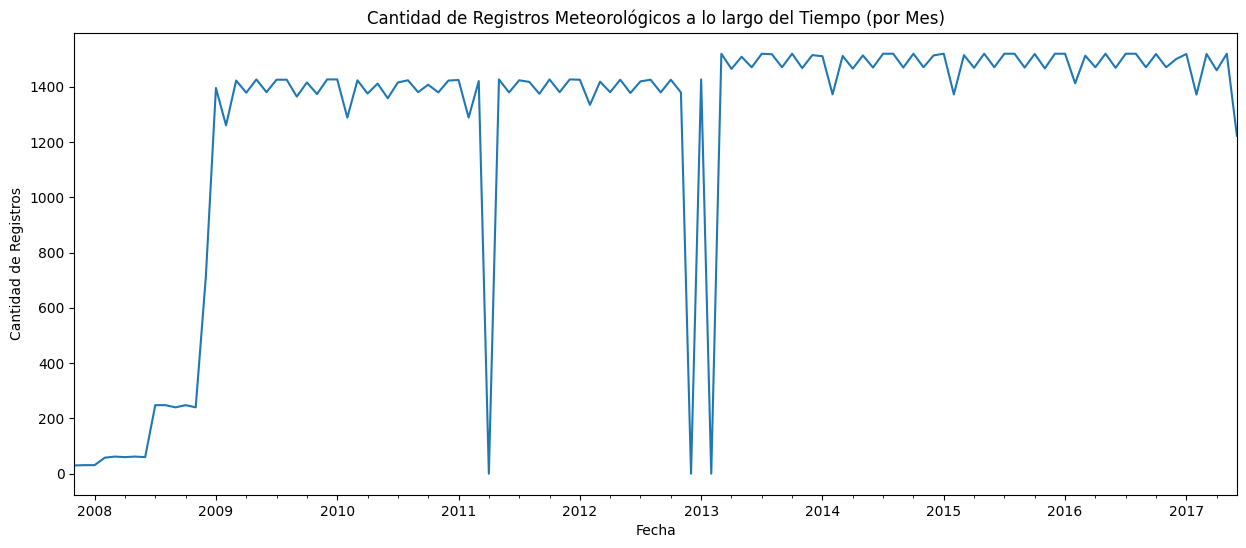

In [137]:
col_temporal = 'Date'

registros_por_mes = df.set_index(col_temporal).resample('M').size()

plt.figure(figsize=(15, 6))
registros_por_mes.plot()
plt.title('Cantidad de Registros Meteorológicos a lo largo del Tiempo (por Mes)')
plt.ylabel('Cantidad de Registros')
plt.xlabel('Fecha')
plt.show()

Por último, mostramos la cantidad de registros según la variable date, notar que presenta pocos registros del año 2008 al 2009, quizás pueda deberse a que se comenzó a implementar la metodología de recolección de datos en ese periodo por lo que muchos de los centros encargados de las mediciones no estaban operativos, luego tambien destacar las caidas de valores presentes en principios del 2011 y en el 2013. Particularmente como en este trabajo no le daremos un enfoque orientado a las series temporales, no suponen a priori un problema mayor estas irregularidades en las fechas.

#### Correlación entre variables

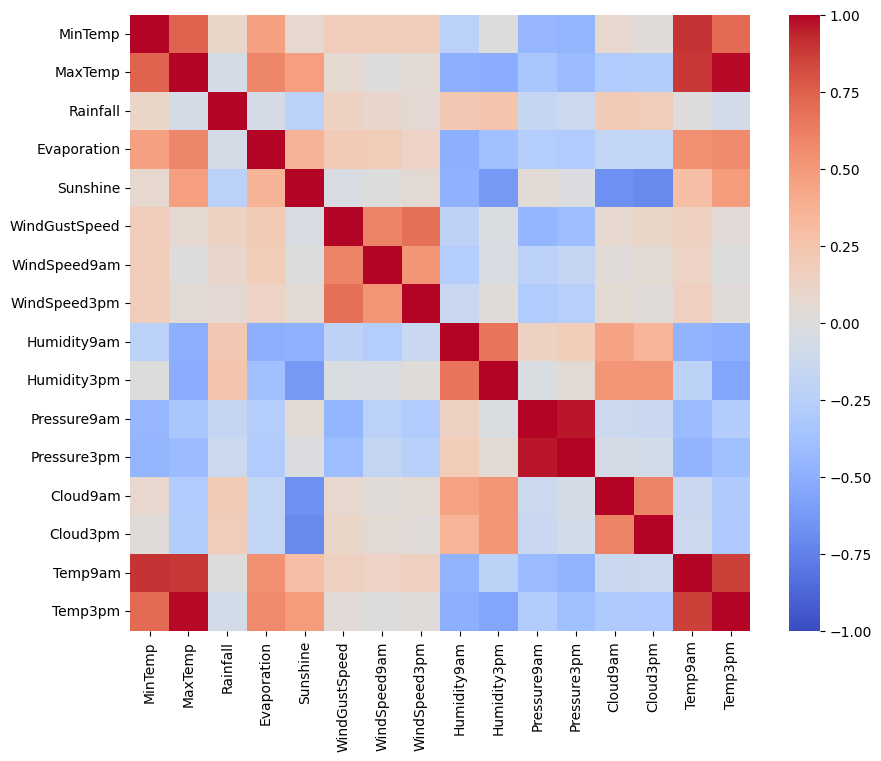

In [138]:
# Correlacion de variables numericas
df_numeric = df.select_dtypes(include=np.number)
# drop de dfnumeric latitud y longitud
df_numeric = df_numeric.drop(columns=['Latitud', 'Longitud'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

En la matriz de correlación podemos observar como existen grupos de variables que están notoriamente correlacionadas entre sí, como lo son lógicamente las que detallan observaciones a las 9am y a las 3pm, por ejemplo la temperatura en esas dos registros o la humedad.


A su vez entre esos mismos grupos podemos apreciar considerables relaciones negativas, como por ejemplo las que indican la nubosidad del cielo (Cloud9am/3pm) respecto de 'Sunshine'.


Podríamos decir que el modelo con todas estas variables presenta una considerable redundancia entre variables tomadas en diferentes momentos del día.


## Analisis clusterización

### División del dataset
- Separamos a la región 'Norfolk Island' porque está alejada del área continental, lo que podría traer consigo valores de variables específicos de esa localidad.
- La zona continental **norte** porque solo son 4 regiones que están lo suficientemente cerca para formar parte del mismo cluster.
- La zona continental **sur** tiene más ciudades por lo que allí ejecutaremos el algoritmo k-means para poder segmentarlas.



In [139]:
# Dividimos el dataset en 3 regiones antes de hacer kmeans

df_NorfolkIsland = df[df['Location'] == 'NorfolkIsland']
df_continental = df[df['Location'] != 'NorfolkIsland']
df_continental_norte = df_continental[df_continental['Latitud'] > -22]
df_continental_sur = df_continental[df_continental['Latitud'] < -22]

In [140]:
# Cantidad de registros por zona:
print(f"Cantidad de registros en Norfolk Island: {len(df_NorfolkIsland)},\nCantidad de registros en Continental Norte: {len(df_continental_norte)},\nCantidad de registros en Continental Sur: {len(df_continental_sur)}")

Cantidad de registros en Norfolk Island: 3009,
Cantidad de registros en Continental Norte: 10851,
Cantidad de registros en Continental Sur: 131251


In [141]:
# Realizamos KMEANS con las ciudades de df_continental_sur

coords = df_coordenadas[['Latitud', 'Longitud']]

kmeans = KMeans(n_clusters=5, random_state=42)
coords['RegionCluster'] = kmeans.fit_predict(coords[['Latitud', 'Longitud']])

# Unimos al DataFrame original
df_clusters = df_continental_sur.merge(coords[['Latitud', 'Longitud', 'RegionCluster']],
                              on=['Latitud', 'Longitud'], how='left')

In [142]:
# A los otros 2 sub dataset agregamos un numero como si fueran clusters a parte

df_continental_norte['RegionCluster'] = 4
df_NorfolkIsland['RegionCluster'] = 5

/tmp/ipython-input-2463662621.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2463662621.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [143]:
# Volvemos a juntar los 3 sub dataset de vuelta en 1

df_final = pd.concat([df_clusters, df_continental_norte, df_NorfolkIsland], ignore_index=True)
len(df_final)

145111

### Mapa de Australia con clusters

In [144]:
# Convertimos cluster a string para mejor visualización de colores
df_final['RegionCluster_str'] = df_final['RegionCluster'].astype(str)

fig = px.scatter_map(
    df_final,
    lat='Latitud',
    lon='Longitud',
    color='RegionCluster_str',
    color_discrete_sequence=px.colors.qualitative.Set1,
    zoom=2.5,
    height=600,
    title='Mapa de Clústeres por Región',
    labels={'RegionCluster_str': 'Cluster'}
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [145]:
# Eliminamos la columna creada para graficar
df_final.drop(columns='RegionCluster_str', inplace=True)

La foto fue sacada de la pagina del clima del gobierno de Australia que muestra diferentes regiones de tipos de clima para comparar con los clusters y basarnos en estos para determinar el tamaño de k.

https://www.bom.gov.au/climate/maps/averages/climate-classification/?maptype=seasgrpb

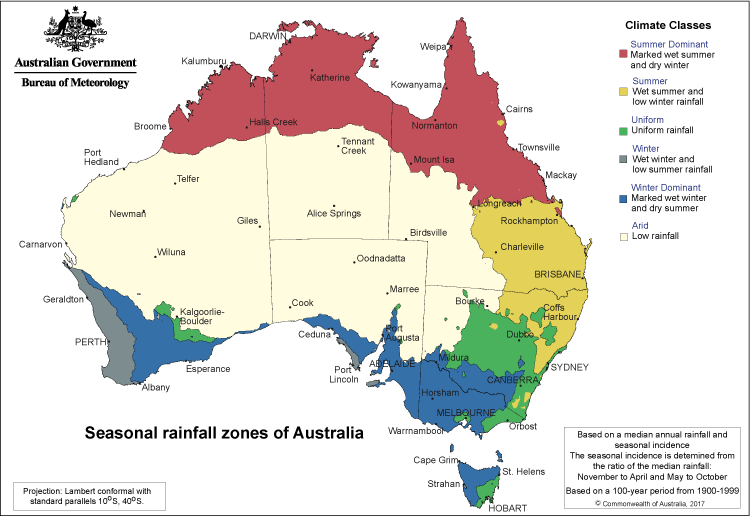

# Imputación de datos faltantes




En esta etapa del trabajo, nos disponemos a completar el dataset imputando los valores que no están presentes, para ello tomamos algunos criterios particulares:
- Para las variables que detallan una observación a las 9am y a las 3pm creamos una función que recibe el un dataframe (train o test), recibe las dos variables en cuestión (por ejemplo 'Humidity9am' y 'Humidity3pm'), un ratio correspondiente de la variable vespertina frente a la matutina y por último otro ratio que refleja lo opuesto, desde la matutina a la vespertina.




  Su funcionamiento de forma compacta es el siguiente, la función si detecta que le falta alguno de los dos valores en esas variables, toma el ratio correspondiente y rellena sabiendo que por ejemplo en promedio x1 es el 60% de x2, por lo tanto rellena x1 = x2* 0.6.




  De esa forma generamos valores para dichas variables que son más verosímiles con la realidad en lugar de tomar algún promedio o media general.




- Para variables numéricas que no corresponden al anterior grupo se realizó una imputación por mediana agrupada, es decir tomamos dicha medida del resultado de realizar la agrupación por la variable 'Location' y a su vez por 'Month', de esa manera obtenemos nuevos registros que pueden ser más cercanos a los valores reales en lugar de realizar solamente una mediana global, además esta función realiza los cálculos con el conjunto de train para luego aplicarlos sobre test y de esta forma evitar la fuga de datos.




- Por último para las variables categóricas tomamos el criterio de rellenar los valores faltantes con la moda de las mismas, además podemos observar en los gráficos resultantes que las distribuciones luego de esa imputación no presentan grandes diferencias.




In [146]:
# Agregamos columna mes para hacer imputaciones basadas en los valores de un mismo periodo
df_final['Month'] = df_final['Date'].dt.month

#### División Train Test

In [147]:
# Dividimos en test y train
train, test = train_test_split(df_final, test_size=0.2, random_state=42)

#### Funciones para imputar

In [26]:
# Funcion para imputar valores pertenecientes a distintas mediciones del mismo dia
def impute_pair_cross(df, var1, var2, ratio_1_to_2, ratio_2_to_1):
    """
    Imputa valores usando la otra medición del mismo día
    con ratios precalculados

    Parameters:
    -----------
    df : DataFrame
    var1 : str - nombre de la primera variable (ej: 'MinTemp', 'Humidity9am')
    var2 : str - nombre de la segunda variable (ej: 'MaxTemp', 'Humidity3pm')
    ratio_1_to_2 : float - ratio de var1/var2
    ratio_2_to_1 : float - ratio de var2/var1
    """
    df_imputed = df.copy()

    # Imputar var1 usando var2
    mask_missing_1 = df_imputed[var1].isna() & df_imputed[var2].notna()
    df_imputed.loc[mask_missing_1, var1] = df_imputed.loc[mask_missing_1, var2] * ratio_1_to_2

    # Imputar var2 usando var1
    mask_missing_2 = df_imputed[var2].isna() & df_imputed[var1].notna()
    df_imputed.loc[mask_missing_2, var2] = df_imputed.loc[mask_missing_2, var1] * ratio_2_to_1

    return df_imputed


In [27]:
def imputar_test(train, test, columna):
    test = test.copy()
    mediana = train.groupby(['Location', 'Month'])[columna].median().reset_index()
    mediana = mediana.rename(columns={columna: columna + '_mediana'})
    test = test.merge(mediana, on=['Location', 'Month'], how='left')
    test[columna] = test[columna].fillna(test[columna + '_mediana'])
    return test.drop(columns=[columna + '_mediana'])

In [28]:
# Calculamos la moda para las variables categoricas
def moda(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

### Humedad 9am y humedad 3pm

In [29]:
# Correlacion entre Humidity9am y Humidity3pm
train[['Humidity9am', 'Humidity3pm']].corr()

Humidity9am  Humidity3pm
Humidity9am     1.000000     0.667283
Humidity3pm     0.667283     1.000000

In [30]:
pd.concat(
    {'train': train[['Humidity9am', 'Humidity3pm']].isnull().sum(),
      'test':  test[['Humidity9am', 'Humidity3pm']].isnull().sum()}, axis=1)

train  test
Humidity9am   1821   484
Humidity3pm   3316   846

In [31]:
# Como esas dos variables tienen una correlacion significativa imputamos las faltantes en una con el dato de la otra para el mismo dia

ratio_3pm_to_9am = (train['Humidity3pm'] / train['Humidity9am']).median()
ratio_9am_to_3pm = (train['Humidity9am'] / train['Humidity3pm']).median()


# Aplicamos la imputación a train y test usando las mismas estadísticas
train = impute_pair_cross(train, 'Humidity9am', 'Humidity3pm', ratio_3pm_to_9am, ratio_9am_to_3pm)
test = impute_pair_cross(test, 'Humidity9am', 'Humidity3pm', ratio_3pm_to_9am, ratio_9am_to_3pm)

In [32]:
# Valores de humedad faltantes en las dos mediciones
pd.concat(
    {'train': train[['Humidity9am', 'Humidity3pm']].isnull().sum(),
      'test':  test[['Humidity9am', 'Humidity3pm']].isnull().sum()}, axis=1)

train  test
Humidity9am   1212   330
Humidity3pm   1212   330

Para imputar los registros en donde no tenemos ninguna de las 2 variables, tomamos la mediana de los valores en la misma ubicación y el mismo mes para imputarlos.

In [33]:
# Como esas dos variables tienen una correlación significativa imputamos las faltantes basándonos en la diferencia porcentual que tienen la temperatura máxima con la mínima
train['Humidity9am'] = train.groupby(['Location', 'Month'])['Humidity9am'].transform(lambda x: x.fillna(x.median()))
train['Humidity3pm'] = train.groupby(['Location', 'Month'])['Humidity3pm'].transform(lambda x: x.fillna(x.median()))

In [34]:
# Imputamos los valores en test
test = imputar_test(train, test, 'Humidity9am')
test = imputar_test(train, test, 'Humidity3pm')

In [35]:
pd.concat(
    {'train': train[['Humidity9am', 'Humidity3pm']].isnull().sum(),
      'test':  test[['Humidity9am', 'Humidity3pm']].isnull().sum()}, axis=1)

train  test
Humidity9am      0     0
Humidity3pm      0     0

### Temperatura máxima y mínima

In [36]:
train[['MinTemp', 'MaxTemp']].corr()

MinTemp   MaxTemp
MinTemp  1.000000  0.736965
MaxTemp  0.736965  1.000000

In [37]:
pd.concat(
    {'train': train[['MinTemp', 'MaxTemp']].isnull().sum(),
      'test':  test[['MinTemp', 'MaxTemp']].isnull().sum()}, axis=1)

train  test
MinTemp    908   237
MaxTemp    754   192

In [38]:
# Como esas dos variables tienen una correlación significativa imputamos las faltantes basándonos en la diferencia porcentual que tienen la temperatura máxima con la mínima
ratio_min_to_max = (train['MinTemp'] / train['MaxTemp']).median()
ratio_max_to_min = (train['MaxTemp'] / train['MinTemp']).median()

train = impute_pair_cross(train, 'MinTemp', 'MaxTemp', ratio_min_to_max, ratio_max_to_min)
test = impute_pair_cross(test, 'MinTemp', 'MaxTemp', ratio_min_to_max, ratio_max_to_min)


In [39]:
pd.concat(
    {'train': train[['MinTemp', 'MaxTemp']].isnull().sum(),
      'test':  test[['MinTemp', 'MaxTemp']].isnull().sum()}, axis=1)

train  test
MinTemp    431   121
MaxTemp    431   121

Para imputar los registros en donde no tenemos ninguna de las 2 variables, tomamos la mediana de los valores en la misma ubicación y el mismo mes para imputarlos



In [40]:
# Imputamos los valores en train
train['MinTemp'] = train.groupby(['Location', 'Month'])['MinTemp'].transform(lambda x: x.fillna(x.median()))
train['MaxTemp'] = train.groupby(['Location', 'Month'])['MaxTemp'].transform(lambda x: x.fillna(x.median()))

In [41]:
# Imputamos los valores en test
test = imputar_test(train, test, 'MinTemp')
test = imputar_test(train, test, 'MaxTemp')

In [42]:
pd.concat(
    {'train': train[['MinTemp', 'MaxTemp']].isnull().sum(),
      'test':  test[['MinTemp', 'MaxTemp']].isnull().sum()}, axis=1)

train  test
MinTemp      0     0
MaxTemp      0     0

### Temperatura 9am y temperatura 3pm

In [43]:
train[['Temp9am', 'Temp3pm']].corr()

Temp9am   Temp3pm
Temp9am  1.000000  0.860694
Temp3pm  0.860694  1.000000

In [44]:
pd.concat(
    {'train': train[['Temp9am', 'Temp3pm']].isnull().sum(),
      'test':  test[['Temp9am', 'Temp3pm']].isnull().sum()}, axis=1)

train  test
Temp9am   1126   292
Temp3pm   2611   653

In [45]:
# Como esas dos variables tienen una correlación significativa imputamos las faltantes basándonos en la diferencia porcentual que tienen la temperatura máxima con la mínima
ratio_9am_to_3pm= (train['Temp9am'] / train['Temp3pm']).median()
ratio_3pm_to_9am = (train['Temp3pm'] / train['Temp9am']).median()

train = impute_pair_cross(train, 'Temp9am', 'Temp3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)
test = impute_pair_cross(test, 'Temp9am', 'Temp3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)


In [46]:
pd.concat(
    {'train': train[['Temp9am', 'Temp3pm']].isnull().sum(),
      'test':  test[['Temp9am', 'Temp3pm']].isnull().sum()}, axis=1)

train  test
Temp9am    614   170
Temp3pm    614   170

Para imputar los registros en donde no tenemos ninguna de las 2 variables, tomamos la mediana de los valores en la misma ubicación y el mismo mes para imputarlos.

In [47]:
# Imputamos los valores en train
train['Temp9am'] = train.groupby(['Location', 'Month'])['Temp9am'].transform(lambda x: x.fillna(x.median()))
train['Temp3pm'] = train.groupby(['Location', 'Month'])['Temp3pm'].transform(lambda x: x.fillna(x.median()))

In [48]:
# Imputamos los valores en test
test = imputar_test(train, test, 'Temp9am')
test = imputar_test(train, test, 'Temp3pm')

In [49]:
pd.concat(
    {'train': train[['Temp9am', 'Temp3pm']].isnull().sum(),
      'test':  test[['Temp9am', 'Temp3pm']].isnull().sum()}, axis=1)

train  test
Temp9am      0     0
Temp3pm      0     0

### Presion 9am y presion 3pm

In [50]:
train[['Pressure9am', 'Pressure3pm']].corr()

Pressure9am  Pressure3pm
Pressure9am      1.00000      0.96142
Pressure3pm      0.96142      1.00000

In [51]:
pd.concat(
    {'train': train[['Pressure9am', 'Pressure3pm']].isnull().sum(),
      'test':  test[['Pressure9am', 'Pressure3pm']].isnull().sum()}, axis=1)

train  test
Pressure9am  11789  2932
Pressure3pm  11757  2927

In [52]:
# Como esas dos variables tienen una correlación significativa imputamos las faltantes basándonos en la diferencia porcentual que tienen la temperatura máxima con la mínima
ratio_9am_to_3pm= (train['Pressure9am'] / train['Pressure3pm']).median()
ratio_3pm_to_9am = (train['Pressure3pm'] / train['Pressure9am']).median()

train = impute_pair_cross(train, 'Pressure9am', 'Pressure3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)
test = impute_pair_cross(test, 'Pressure9am', 'Pressure3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)


In [53]:
pd.concat(
    {'train': train[['Pressure9am', 'Pressure3pm']].isnull().sum(),
      'test':  test[['Pressure9am', 'Pressure3pm']].isnull().sum()}, axis=1)

train  test
Pressure9am  11579  2881
Pressure3pm  11579  2881

Para imputar los registros en donde no tenemos ninguna de las 2 variables, tomamos la mediana de los valores en la misma región (cluster) y el mismo mes para imputarlos. Ampliamos el foco del cálculo del estadístico porque hay ubicaciones que no tienen registro de presión por lo tanto usamos los registros de la región.



In [54]:
# Imputamos los valores en train
train['Pressure9am'] = train.groupby(['RegionCluster', 'Month'])['Pressure9am'].transform(lambda x: x.fillna(x.mean()))
train['Pressure3pm'] = train.groupby(['RegionCluster', 'Month'])['Pressure3pm'].transform(lambda x: x.fillna(x.mean()))

In [55]:
# Imputamos los valores en test
test = imputar_test(train, test, 'Pressure9am')
test = imputar_test(train, test, 'Pressure3pm')

In [56]:
pd.concat(
    {'train': train[['Pressure9am', 'Pressure3pm']].isnull().sum(),
      'test':  test[['Pressure9am', 'Pressure3pm']].isnull().sum()}, axis=1)

train  test
Pressure9am      0     0
Pressure3pm      0     0

### Velocidad viento 9am y velocidad viento 3pm

In [57]:
train[['WindSpeed9am', 'WindSpeed3pm']].corr()

WindSpeed9am  WindSpeed3pm
WindSpeed9am      1.000000      0.518751
WindSpeed3pm      0.518751      1.000000

In [58]:
pd.concat(
    {'train': train[['WindSpeed9am', 'WindSpeed3pm']].isnull().sum(),
      'test':  test[['WindSpeed9am', 'WindSpeed3pm']].isnull().sum()}, axis=1)

train  test
WindSpeed9am   1135   283
WindSpeed3pm   2166   549

Como la relacion de las dos variables no es tan considerable,imputamos los registros tomando la mediana de los valores en la misma ubicacion y el mismo mes.

In [59]:
# Imputamos los valores en train
train['WindSpeed9am'] = train.groupby(['Location', 'Month'])['WindSpeed9am'].transform(lambda x: x.fillna(x.median()))
train['WindSpeed3pm'] = train.groupby(['Location', 'Month'])['WindSpeed3pm'].transform(lambda x: x.fillna(x.median()))

In [60]:
# Imputamos los valores en test
test = imputar_test(train, test, 'WindSpeed9am')
test = imputar_test(train, test, 'WindSpeed3pm')

In [61]:
pd.concat(
    {'train': train[['WindSpeed9am', 'WindSpeed3pm']].isnull().sum(),
      'test':  test[['WindSpeed9am', 'WindSpeed3pm']].isnull().sum()}, axis=1)

train  test
WindSpeed9am      0     0
WindSpeed3pm      0     0

### Cloud9am y Cloud3pm

In [62]:
# eliminamos registros que en 'Cloud9am', 'Cloud3pm' el valores sea igual a 9

train = train[~((train['Cloud9am'] == 9) | (train['Cloud3pm'] == 9))]

test = test[~((test['Cloud9am'] == 9) | (test['Cloud3pm'] == 9))]


In [63]:
train[['Cloud9am', 'Cloud3pm']].corr()

Cloud9am  Cloud3pm
Cloud9am  1.000000  0.603089
Cloud3pm  0.603089  1.000000

In [64]:
pd.concat(
    {'train': train[['Cloud9am', 'Cloud3pm']].isnull().sum(),
      'test':  test[['Cloud9am', 'Cloud3pm']].isnull().sum()}, axis=1)

train   test
Cloud9am  44513  11027
Cloud3pm  47287  11722

In [65]:
# Como esas dos variables tienen una correlación significativa imputamos las faltantes basándonos en la diferencia porcentual que tienen la temperatura máxima con la mínima
ratio_9am_to_3pm= (train['Cloud9am'] / train['Cloud3pm']).median()
ratio_3pm_to_9am = (train['Cloud3pm'] / train['Cloud9am']).median()

train = impute_pair_cross(train, 'Cloud9am', 'Cloud3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)
test = impute_pair_cross(test, 'Cloud9am', 'Cloud3pm', ratio_9am_to_3pm, ratio_3pm_to_9am)


In [66]:
pd.concat(
    {'train': train[['Cloud9am', 'Cloud3pm']].isnull().sum(),
      'test':  test[['Cloud9am', 'Cloud3pm']].isnull().sum()}, axis=1)

train   test
Cloud9am  41196  10200
Cloud3pm  41196  10200

Al igual que con  Pressure9am y Pressure3pm para imputar los registros en donde no tenemos ninguna de las 2 variables tomamos la mediana de los valores en la misma region y el mismo mes para imputarlos porque no tenemos suficientes datos en la ubicacion.

In [67]:
# Imputamos los valores en train
train['Cloud9am'] = train.groupby(['RegionCluster', 'Month'])['Cloud9am'].transform(lambda x: x.fillna(x.median()))
train['Cloud3pm'] = train.groupby(['RegionCluster', 'Month'])['Cloud3pm'].transform(lambda x: x.fillna(x.median()))

In [68]:
# Imputamos los valores en test
test = imputar_test(train, test, 'Cloud9am')
test = imputar_test(train, test, 'Cloud3pm')

In [69]:
pd.concat(
    {'train': train[['Cloud9am', 'Cloud3pm']].isnull().sum(),
      'test':  test[['Cloud9am', 'Cloud3pm']].isnull().sum()}, axis=1)

train  test
Cloud9am      0     0
Cloud3pm      0     0

### WindGustSpeed

Para imputar los valores faltantes de la velocidad de rafaga mas alta de viento asumimos el valor mas alto entre la velocidad registrada a las 9am y a las 3pm.

In [70]:
pd.concat(
    {'train': train[['WindGustSpeed']].isnull().sum(),
      'test':  test[['WindGustSpeed']].isnull().sum()}, axis=1)

train  test
WindGustSpeed   7936  1980

In [71]:
train['WindGustSpeed'] = train['WindGustSpeed'].fillna(train[['WindSpeed9am', 'WindSpeed3pm']].max(axis=1))

test['WindGustSpeed'] = test['WindGustSpeed'].fillna(test[['WindSpeed9am', 'WindSpeed3pm']].max(axis=1))

In [72]:
pd.concat(
    {'train': train[['WindGustSpeed']].isnull().sum(),
      'test':  test[['WindGustSpeed']].isnull().sum()}, axis=1)

train  test
WindGustSpeed      0     0

### Rainfall

In [73]:
pd.concat(
    {'train': train[['Rainfall']].isnull().sum(),
      'test':  test[['Rainfall']].isnull().sum()}, axis=1)

train  test
Rainfall   2371   593

In [74]:
train['Rainfall'] = train.groupby(['Location', 'Month'])['Rainfall'].transform(lambda x: x.fillna(x.median()))
test = imputar_test(train, test, 'Rainfall')

In [75]:
pd.concat(
    {'train': train[['Rainfall']].isnull().sum(),
      'test':  test[['Rainfall']].isnull().sum()}, axis=1)

train  test
Rainfall      0     0

### Evaporation y Sunshine

In [76]:
pd.concat(
    {'train': train[['Evaporation', 'Sunshine']].isnull().sum(),
      'test':  test[['Evaporation', 'Sunshine']].isnull().sum()}, axis=1)

train   test
Evaporation  50024  12481
Sunshine     55741  13809

In [77]:
# Imputamos los valores en train
train['Evaporation'] = train.groupby(['RegionCluster', 'Month'])['Evaporation'].transform(lambda x: x.fillna(x.median()))
train['Sunshine'] = train.groupby(['RegionCluster', 'Month'])['Sunshine'].transform(lambda x: x.fillna(x.median()))

In [78]:
# Imputamos los valores en test
test = imputar_test(train, test, 'Evaporation')
test = imputar_test(train, test, 'Sunshine')

In [79]:
pd.concat(
    {'train': train[['Evaporation', 'Sunshine']].isnull().sum(),
      'test':  test[['Evaporation', 'Sunshine']].isnull().sum()}, axis=1)

train  test
Evaporation      0     0
Sunshine         0     0

### WindGustDir, WindDir9am y WindDir3pm

In [80]:
pd.concat(
    {'train': train[['WindDir9am', 'WindDir3pm']].isnull().sum(),
      'test':  test[['WindDir9am', 'WindDir3pm']].isnull().sum()}, axis=1)

train  test
WindDir9am   8178  2039
WindDir3pm   3094   787

In [81]:
modas_por_region = train.groupby('RegionCluster')[['WindGustDir', 'WindDir9am', 'WindDir3pm']].agg(moda)

# Unimos para obtener la moda correspondiente a cada registro
train = train.merge(modas_por_region, on='RegionCluster', suffixes=('', '_moda'))

# Para cada variable categórica, completamos los NaN con la moda de su región
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    train[col] = train[col].fillna(train[f'{col}_moda'])
    train.drop(columns=f'{col}_moda', inplace=True)


test = test.merge(modas_por_region, on='RegionCluster', suffixes=('', '_moda'))

for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    test[col] = test[col].fillna(test[f'{col}_moda'])
    test.drop(columns=f'{col}_moda', inplace=True)

In [82]:
pd.concat(
    {'train': train[['WindDir9am', 'WindDir3pm']].isnull().sum(),
      'test':  test[['WindDir9am', 'WindDir3pm']].isnull().sum()}, axis=1)

train  test
WindDir9am      0     0
WindDir3pm      0     0

### RainToday y RainTomorrow

In [83]:
pd.concat(
    {'train': train[['RainToday', 'RainTomorrow']].isnull().sum(),
      'test':  test[['RainToday', 'RainTomorrow']].isnull().sum()}, axis=1)

train  test
RainToday      2371   593
RainTomorrow   2378   610

In [84]:
modas_por_region = train.groupby('RegionCluster')[['RainToday', 'RainTomorrow']].agg(moda)

# Unimos para obtener la moda correspondiente a cada registro
train = train.merge(modas_por_region, on='RegionCluster', suffixes=('', '_moda'))

# Para cada variable categórica, completamos los NaN con la moda de su región
for col in ['RainToday', 'RainTomorrow']:
    train[col] = train[col].fillna(train[f'{col}_moda'])
    train.drop(columns=f'{col}_moda', inplace=True)


test = test.merge(modas_por_region, on='RegionCluster', suffixes=('', '_moda'))

for col in ['RainToday', 'RainTomorrow']:
    test[col] = test[col].fillna(test[f'{col}_moda'])
    test.drop(columns=f'{col}_moda', inplace=True)

En la celda siguiente modificamos el valor de la variable 'RainToday' según si el registro de la variable 'Rainfall' es mayor a cero, es decir, si se registraron en ese día precipitaciones, se indica que llovió.



In [85]:
# rellenamos los valores de RainToday con Yes si rainfall es mayor a cero

train.loc[train['Rainfall'] > 0, 'RainToday'] = 'Yes'
test.loc[test['Rainfall'] > 0, 'RainToday'] = 'Yes'

train.loc[train['Rainfall'] == 0, 'RainToday'] = 'No'
test.loc[test['Rainfall'] == 0, 'RainToday'] = 'No'

In [86]:
pd.concat(
    {'train': train[['RainToday', 'RainTomorrow']].isnull().sum(),
      'test':  test[['RainToday', 'RainTomorrow']].isnull().sum()}, axis=1)

train  test
RainToday         0     0
RainTomorrow      0     0

### Convertimos 'RainToday' y 'RainTomorrow' a valores booleanos (0 y 1)

In [87]:
#Mapeamos los 'yes' a 1 y 'no' a 0
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})


test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})

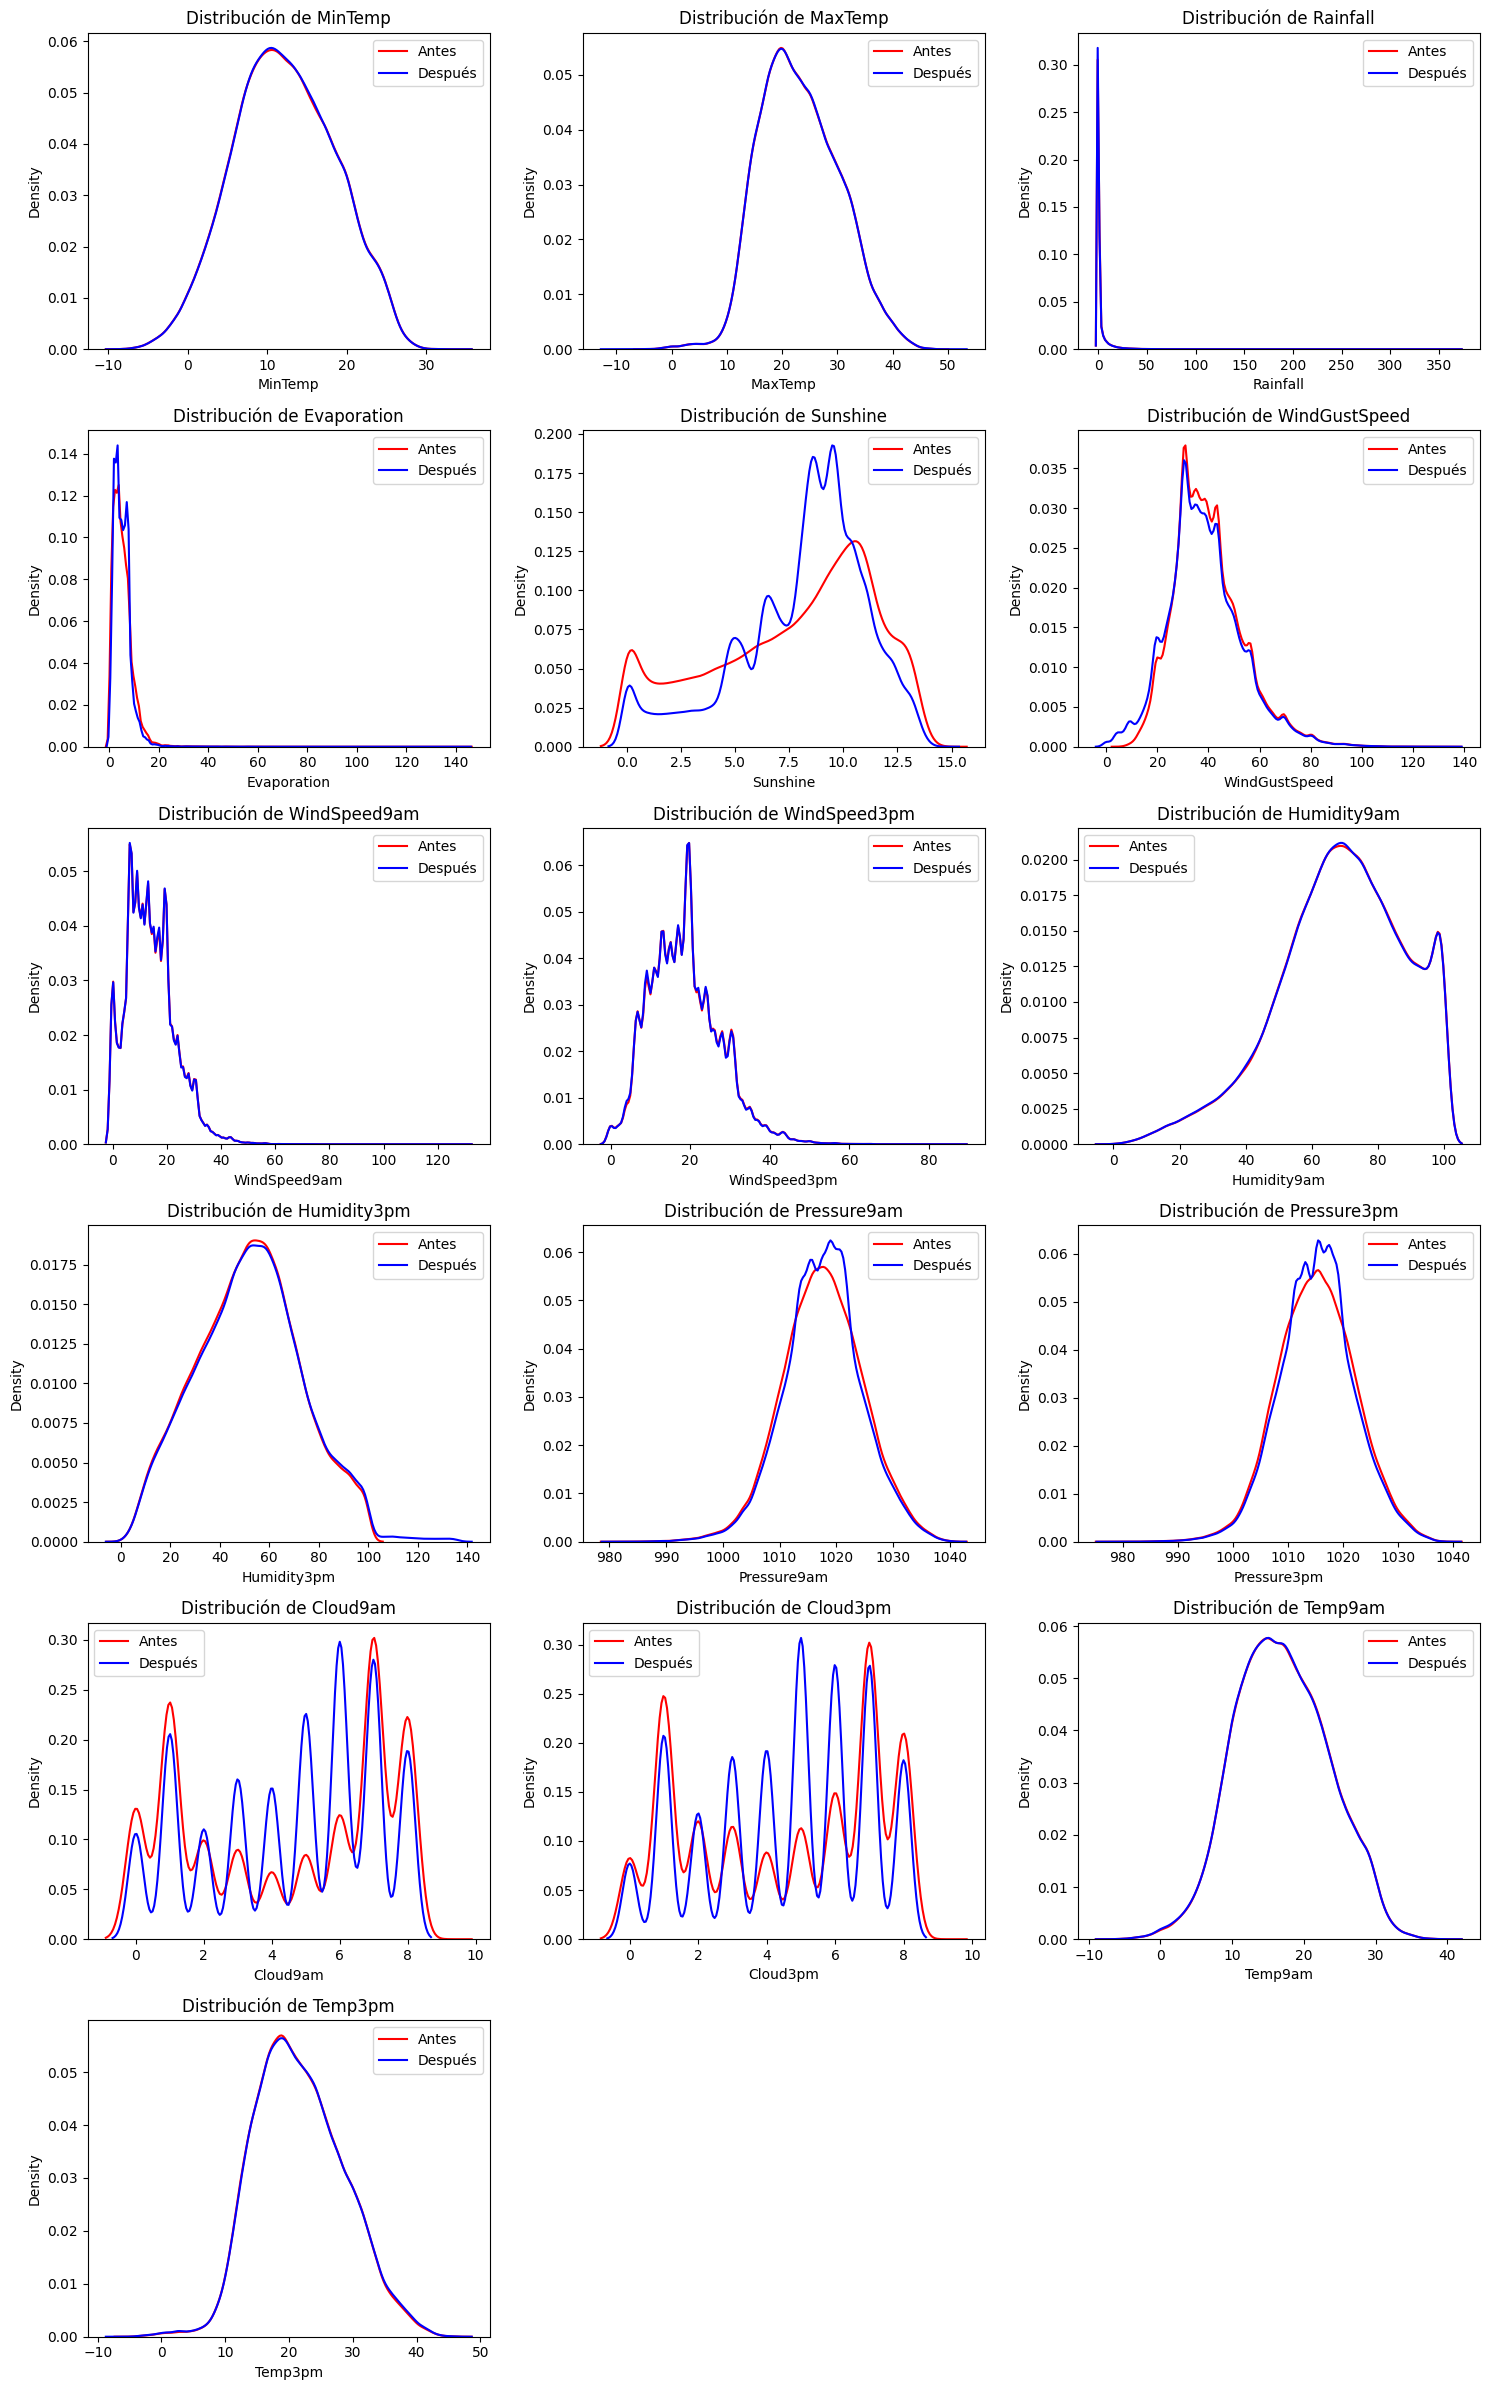

In [88]:
# unimos train y test en un dataframe para analizar las distribuciones antes y despues de imputar datos

df_after = pd.concat([train, test])
cols =  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation','Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm']

n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols  # filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    # Distribución antes de imputar
    sns.kdeplot(df_final[col].dropna(), ax=axes[i], color='red', label='Antes', fill=False)
    # Distribución después de imputar
    sns.kdeplot(df_after[col].dropna(), ax=axes[i], color='blue', label='Después', fill=False)

    axes[i].set_title(f'Distribución de {col}')
    axes[i].legend()

# Eliminar ejes vacíos si los hay
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Luego de terminar con las imputaciones de los datos faltantes, realizamos gráficos para comprobar las distribuciones antes y después de rellenarlos, podemos observar que en su gran mayoría el comportamiento de las mismas no se encuentra casi modificado.


Por el contrario variables como 'Sunshine' que tenía una gran cantidad de valores faltantes, vio bastante modificada su distribución pero es un fenómeno que se nos escapa, ya que como dijimos antes, presentaba una gran parte de valores faltantes, por lo que inevitablemente se vio modificada su distribución.


Por último las encargadas de medir la nubosidad en octas, también presentan diferencias considerables, aquí el causante de ello es que existían muchos registros donde faltaban las observaciones de ambos registros, por lo que allí la precisión a la hora de rellenar fue algo menor.


## Codificación de variables


Para la codificación de variables categóricas realizamos múltiples transformaciones:
- Para aquellas que marcan la dirección del viento, tomamos el criterio de realizar la codificación cíclica para inicialmente transformarlas en números y además para que conserven su continuidad entre ellas.
- Luego para las variables que detallan dos observaciones de la misma a lo largo del día (9am y 3pm) creamos una nueva variable que expresa la diferencia entre las mismas, de esa forma podemos agregar complejidad al modelo con la intención de capturar relaciones que quizás inicialmente no estábamos observando.
- Para las variables como mes y región, tomamos la decisión de realizar una codificación One Hot Encoding, lo que en consecuencia nos genera múltiples columnas.



In [89]:
# Realizamos codificacion seno y coseno con variables ciclicas

wind_dir_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5}

train['WindGustDir'] = train['WindGustDir'].map(wind_dir_map)
train['WindGustDir_sin'] = np.sin(np.deg2rad(train['WindGustDir']))
train['WindGustDir_cos'] = np.cos(np.deg2rad(train['WindGustDir']))

train['WindDir9am'] = train['WindDir9am'].map(wind_dir_map)
train['WindDir9am_sin'] = np.sin(np.deg2rad(train['WindDir9am']))
train['WindDir9am_cos'] = np.cos(np.deg2rad(train['WindDir9am']))

train['WindDir3pm'] = train['WindDir3pm'].map(wind_dir_map)
train['WindDir3pm_sin'] = np.sin(np.deg2rad(train['WindDir3pm']))
train['WindDir3pm_cos'] = np.cos(np.deg2rad(train['WindDir3pm']))


test['WindGustDir'] = test['WindGustDir'].map(wind_dir_map)
test['WindGustDir_sin'] = np.sin(np.deg2rad(test['WindGustDir']))
test['WindGustDir_cos'] = np.cos(np.deg2rad(test['WindGustDir']))

test['WindDir9am'] = test['WindDir9am'].map(wind_dir_map)
test['WindDir9am_sin'] = np.sin(np.deg2rad(test['WindDir9am']))
test['WindDir9am_cos'] = np.cos(np.deg2rad(test['WindDir9am']))

test['WindDir3pm'] = test['WindDir3pm'].map(wind_dir_map)
test['WindDir3pm_sin'] = np.sin(np.deg2rad(test['WindDir3pm']))
test['WindDir3pm_cos'] = np.cos(np.deg2rad(test['WindDir3pm']))

In [90]:
# Agregamos columnas con la diferencia de valores entre variables 9am y 3p

train['temp_diff'] = abs(train['Temp9am'] - train['Temp3pm'])
train['humidity_diff'] = abs(train['Humidity9am'] - train['Humidity3pm'])
train['wind_diff'] = abs(train['WindSpeed9am'] - train['WindSpeed3pm'])
train['min_max_diff'] = abs(train['MinTemp'] - train['MaxTemp'])
train['cloud_diff'] = abs(train['Cloud9am'] - train['Cloud3pm'])
train['pressure_diff'] = abs(train['Pressure9am'] - train['Pressure3pm'])


test['temp_diff'] = abs(test['Temp9am'] - test['Temp3pm'])
test['humidity_diff'] = abs(test['Humidity9am'] - test['Humidity3pm'])
test['wind_diff'] = abs(test['WindSpeed9am'] - test['WindSpeed3pm'])
test['min_max_diff'] = abs(test['MinTemp'] - test['MaxTemp'])
test['cloud_diff'] = abs(test['Cloud9am'] - test['Cloud3pm'])
test['pressure_diff'] = abs(test['Pressure9am'] - test['Pressure3pm'])

In [91]:
# Realizmos OHE en train

# Columnas categóricas a transformar
columnas_cat = ['Month', 'RegionCluster']

# Inicializamos el encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Ajustamos y transformamos solo las columnas categóricas
encoded_array = encoder.fit_transform(train[columnas_cat])

# Obtenemos los nombres de las nuevas columnas
encoded_cols = encoder.get_feature_names_out(columnas_cat)

# Convertimos el resultado en DataFrame
df_encoded_train = pd.DataFrame(encoded_array, columns=encoded_cols, index=train.index)

# Concatenamos al DataFrame original
train = pd.concat([train.drop(columns=columnas_cat), df_encoded_train], axis=1)

In [92]:
# REALIZAMOS OHE en test

# Columnas categóricas a transformar
columnas_cat = ['Month', 'RegionCluster']

# Inicializamos el encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Ajustamos y transformamos solo las columnas categóricas
encoded_array = encoder.fit_transform(test[columnas_cat])

# Obtenemos los nombres de las nuevas columnas
encoded_cols = encoder.get_feature_names_out(columnas_cat)

# Convertimos el resultado en DataFrame
df_encoded_test = pd.DataFrame(encoded_array, columns=encoded_cols, index=test.index)

# Concatenamos al DataFrame original
test = pd.concat([test.drop(columns=columnas_cat), df_encoded_test], axis=1)

In [93]:
# Reemplazamos train['Cloud9am'] que sea decimal por entero
train['Cloud9am'] = train['Cloud9am'].astype(int)
train['Cloud3pm'] = train['Cloud3pm'].astype(int)
test['Cloud9am'] = test['Cloud9am'].astype(int)
test['Cloud3pm'] = test['Cloud3pm'].astype(int)

In [94]:
numerical_cols =  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'temp_diff', 'humidity_diff', 'wind_diff', 'min_max_diff', 'cloud_diff',
       'pressure_diff']

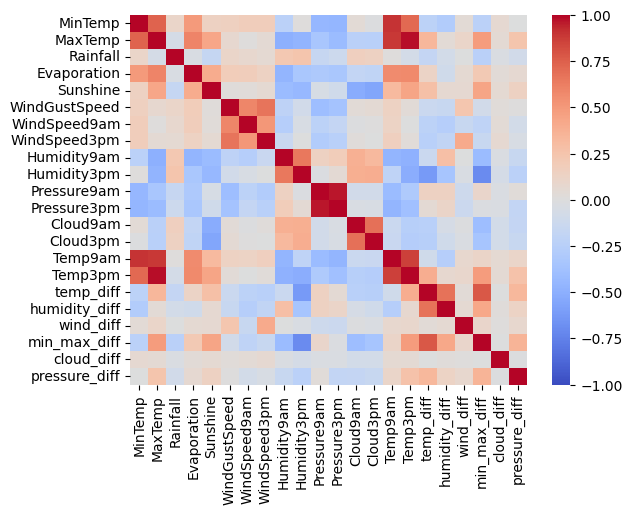

In [95]:
# matriz de correlacion de variables numericas en train
corr_matrix = train[numerical_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Observando la nueva matriz que cuenta con las variables recientemente codificadas, podemos ver que muchas de ellas aportan una correlación lineal significativa, como 'temp_diff' y 'humidity_diff'. En cambio 'cloud_diff' no parece ser relevante para el análisis lineal de las variables respecto a ella.

In [96]:
train.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitud', 'Longitud',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'temp_diff',
       'humidity_diff', 'wind_diff', 'min_max_diff', 'cloud_diff',
       'pressure_diff', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'RegionCluster_1', 'RegionCluster_2', 'RegionCluster_3',
       'RegionCluster_4', 'RegionCluster_5'],
      dtype='object')

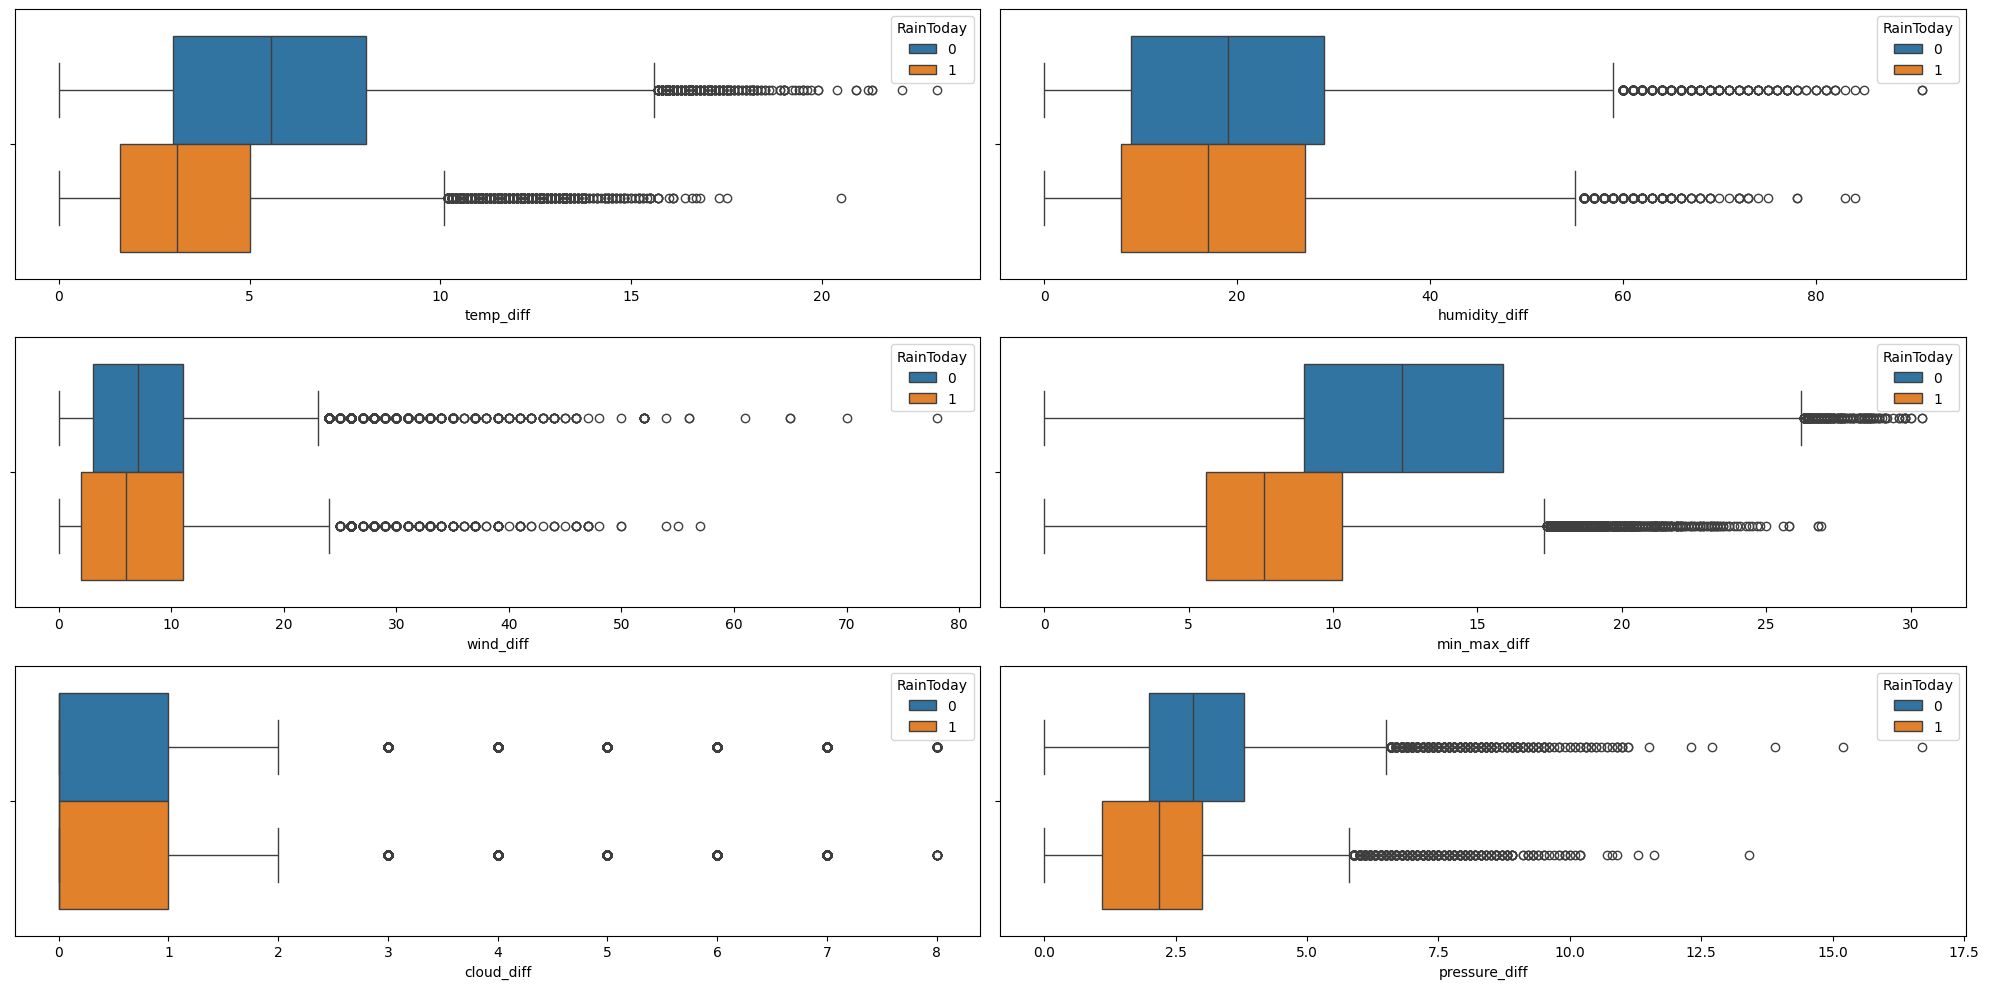

In [97]:
plt.figure(figsize=(20, 10))

plt.subplot(321)
sns.boxplot(data=train, x='temp_diff', hue='RainToday')
plt.subplot(322)
sns.boxplot(data=train, x='humidity_diff', hue='RainToday')
plt.subplot(323)
sns.boxplot(data=train, x='wind_diff', hue='RainToday')
plt.subplot(324)
sns.boxplot(data=train, x='min_max_diff', hue='RainToday')
plt.subplot(325)
sns.boxplot(data=train, x='cloud_diff', hue='RainToday')
plt.subplot(326)
sns.boxplot(data=train, x='pressure_diff', hue='RainToday')

plt.tight_layout()
plt.show()

En estos boxplots queremos observar si las nuevas variables creadas a partir de las diferencias de las ya existentes, aportan información extra respecto a la variable objetivo, y es el caso de por ejemplo de 'temp_diff' y 'min_max_diff' que podemos ver como los boxplots presentan diferencias considerables cuando la variable objetivo es uno o cero.

## Balanceo del dataset
Observamos que el dataset con el que estamos trabajando esta desbalanceado, debido a que naturalmente en esa región hay más días que no llueven de los que sí presentan precipitaciones, es por ello que debemos tomar un criterio a la hora de llevar a cabo el modelo de clasificación para tener en cuenta este desbalance, analizamos que las proporciones son de 80-20, lo que nos expresa una gran diferencia entre los dos valores.



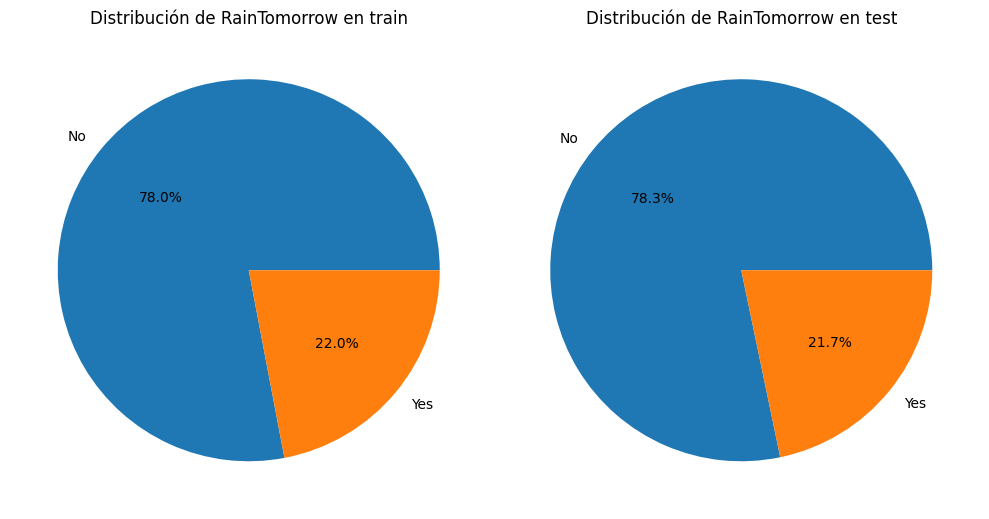

In [98]:
#grafico de sectores para raintomorrow
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.pie(train['RainTomorrow'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Distribución de RainTomorrow en train')
plt.subplot(122)
plt.pie(test['RainTomorrow'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Distribución de RainTomorrow en test')
plt.tight_layout()
plt.show()


## División X e Y

In [99]:
train.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitud', 'Longitud',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'temp_diff',
       'humidity_diff', 'wind_diff', 'min_max_diff', 'cloud_diff',
       'pressure_diff', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'RegionCluster_1', 'RegionCluster_2', 'RegionCluster_3',
       'RegionCluster_4', 'RegionCluster_5'],
      dtype='object')

In [100]:
# División en X e y
X_train = train.drop(columns=['RainTomorrow','Date','Location','WindGustDir','WindDir9am','WindDir3pm','Latitud','Longitud'])
y_train = train['RainTomorrow']
X_test = test.drop(columns=['RainTomorrow','Date','Location','WindGustDir','WindDir9am','WindDir3pm','Latitud','Longitud'])
y_test = test['RainTomorrow']

In [101]:
# variables a escalar
features_escalar = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm','temp_diff',
        'humidity_diff', 'wind_diff', 'min_max_diff', 'cloud_diff', 'pressure_diff']

# escalamos
scaler = RobustScaler()
X_train[features_escalar] = scaler.fit_transform(X_train[features_escalar])
X_test[features_escalar] = scaler.transform(X_test[features_escalar])


# Ejercicio 3 | Modelos de regresión logística y curvas ROC
En esta etapa del trabajo, al contar con el dataset ya transformado y listo para usar comenzamos a probar modelos de clasificación para predecir la variable target, es por ello que implementamos inicialmente cuatro variantes en los modelos:
- Regresión logística
- Regresión logística (con el parámetro balanced)
- Regresión logística con el método Random Oversampling
- Regresión logística con el método SMOTE


Una vez ejecutado cada modelo, observamos su matriz de confusión para ver como es la clasificación que está realizando, acompañado de sus métricas correspondientes por clase, al finalizar concatenamos todos esos resultados en un dataframe para poder compararlos de manera más directa.


Observando dicha estructura de datos podemos apreciar que los modelos con alguna variante de balanceo para regresión logística presentan una leve mejora frente a la alternativa base, ya que por el mismo funcionamiento de las mismas intentan compensar esa diferencia de registros inicial presentes en las fuentes de datos.


Y respecto a los modelos con estas mejoras podemos ver que tienen un puntaje en Recall de la clase minoritaria de 0.77 lo cual es muy bueno pero a costa de perder precisión, por lo que el modelo estaría generando múltiples falsas alarmas de lluvia, es decir tendría muchos falsos positivos. Ponderando estos dos aspectos podemos visualizar la métrica F1 Score que para los tres modelos es de 0.612, lo que respecta a una mejora frente a la regresión logística estándar.


## Valores de la matriz de confusión


- **Verdaderos positivos**: El modelo predice que llovió y así fue.
- **Verdaderos negativos**: El modelo predice que no llovió y así fue.
- **Falsos positivos**: El modelo predice que llovió y no fue así.
- **Falsos negativos**: El modelo predice que no llovió y no fue así.


## Curvas ROC


Una vez terminada la ejecución y la comparativa de métricas de los modelos, graficamos las curvas ROC para cada uno de ellos y podemos ver que todos los modelos tienen un valor AUC aproximado en 0.87, por lo que podemos decir que  todos los modelos tienen una gran capacidad para indicar si es más probable que llueva en un caso que en otro.
Respecto a los umbrales, 0.5 no es el mejor umbral especialmente en problemas desbalanceados como en el que estamos trabajando, particularmente  predecir no llueve es mucho más común que predecir lo contrario, por lo que un umbral óptimo debe ser más bajo, para ello los graficamos junto a las curvas y encontramos los siguientes valores:
- Regresión Logística: Mejor umbral (Youden) = 0.201
- Regresión Logística balanced: Mejor umbral (Youden) = 0.480
- Regresión Logística oversampled: Mejor umbral (Youden) = 0.476
- Regresión Logística SMOTE: Mejor umbral (Youden) = 0.461


## Fitting obtenido


Concluimos que los resultados obtenidos de nuestro ajuste de modelos es aceptable, ya que si observamos la métrica F1 Score que es la que se suele utilizar en problemas desbalanceados, nuestros modelos obtienen un 0.61, lo cual no es un valor muy elevado pero tampoco es como tirar una moneda al aire, quizás esta falta de puntaje extra que podríamos considerar pueda ser causa de la gran cantidad de valores faltantes con el que se presentaba el dataset y a la hora de imputarlos, como es lógico no pudimos representar de forma completa la realidad en esos datos.



# Regresión logística



#### Función para graficar matrices de confusión

In [102]:
# def graficar_matriz_confusion(y_true, y_pred, titulo,
#                              labels=["No llovió", "Llovió"],
#                              cmap=plt.cm.Blues,
#                              ax=None):

#     if ax is None:
#         fig, ax = plt.subplots(figsize=(6, 5))
#         debo_mostrar_plot = True
#     else:
#         debo_mostrar_plot = False

#     cm = confusion_matrix(y_true, y_pred)

#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

#     disp.plot(ax=ax, cmap=cmap, colorbar=False)

#     ax.set_title(titulo)
#     ax.set_xlabel("Predicho")
#     ax.set_ylabel("Real")

#     offset_y = 0.25
#     fuente_size = 14

#     ax.text(0, 0 - offset_y, "TN", ha="center", va="center", color="white", fontsize=fuente_size, weight="bold")
#     ax.text(1, 0 - offset_y, "FP", ha="center", va="center", color="black", fontsize=fuente_size, weight="bold")
#     ax.text(0, 1 - offset_y, "FN", ha="center", va="center", color="black", fontsize=fuente_size, weight="bold")
#     ax.text(1, 1 - offset_y, "TP", ha="center", va="center", color="black", fontsize=fuente_size, weight="bold")

#     if debo_mostrar_plot:
#         plt.tight_layout()
#         plt.show()



In [103]:
def graficar_matriz_confusion(y_true, y_pred, titulo):
    offset_y = 0.25
    fuente_size = 14

    fig, ax = plt.subplots(figsize=(6, 5))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No llovió", "Llovió"])
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)

    ax.set_title(titulo)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    ax.grid(False)


    ax.text(0, 0 - offset_y, "TN", ha="center", va="center", color="white",
            fontsize=fuente_size, weight="bold")

    ax.text(1, 0 - offset_y, "FP", ha="center", va="center", color="black",
            fontsize=fuente_size, weight="bold")

    ax.text(0, 1 - offset_y, "FN", ha="center", va="center", color="black",
            fontsize=fuente_size, weight="bold")

    ax.text(1, 1 - offset_y, "TP", ha="center", va="center", color="black",
            fontsize=fuente_size, weight="bold")

    plt.show()

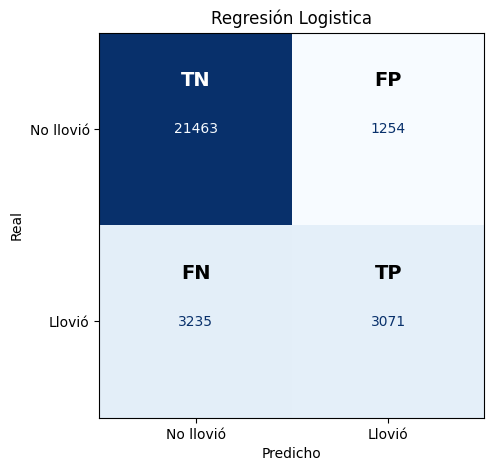

Resultados con regresión logística (dataset desbalanceado):


Clase  Precision  Recall  F1-score  Accuracy
0      0      0.869   0.945     0.905     0.845
1      1      0.710   0.487     0.578     0.845

In [104]:
regresionLogistica = LogisticRegression(random_state=42, max_iter=1000)
regresionLogistica.fit(X_train, y_train)
y_pred_log = regresionLogistica.predict(X_test)


graficar_matriz_confusion(y_test, y_pred_log, "Regresión Logistica")

# Metricas
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log, average=None)
recall = recall_score(y_test, y_pred_log, average=None)
f1 = f1_score(y_test, y_pred_log, average=None)
# Obtenemos los nombres de las clases
classes = sorted(list(set(y_test)))

# Creamos el DataFrame
resultados_logistica = pd.DataFrame({
    'Clase': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1})

resultados_logistica['Accuracy'] = accuracy

print("Resultados con regresión logística (dataset desbalanceado):")
display(resultados_logistica.round(3))


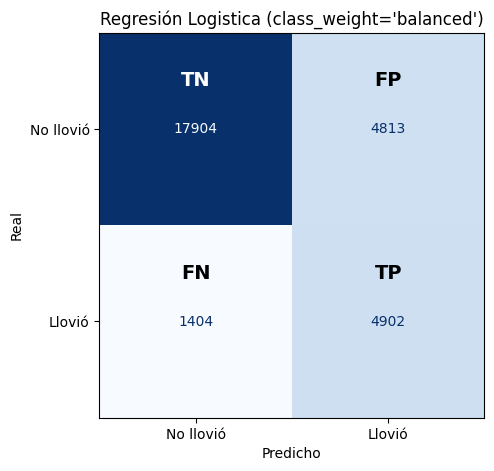

Resultados Regresión Logistica (class_weight='balanced'):


Clase  Precision  Recall  F1-score  Accuracy
0      0      0.927   0.788     0.852     0.786
1      1      0.505   0.777     0.612     0.786

In [105]:
regresionLogistica_balanced = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
regresionLogistica_balanced.fit(X_train, y_train)
y_pred_log_balanced = regresionLogistica_balanced.predict(X_test)



graficar_matriz_confusion(y_test, y_pred_log_balanced, "Regresión Logistica (class_weight='balanced')")

# Metricas
accuracy = accuracy_score(y_test, y_pred_log_balanced)
precision = precision_score(y_test, y_pred_log_balanced, average=None)
recall = recall_score(y_test, y_pred_log_balanced, average=None)
f1 = f1_score(y_test, y_pred_log_balanced, average=None)
# Obtenemos los nombres de las clases
classes = sorted(list(set(y_test)))

# Creamos el DataFrame
resultados_balanceada = pd.DataFrame({
    'Clase': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1})

resultados_balanceada['Accuracy'] = accuracy

print("Resultados Regresión Logistica (class_weight='balanced'):")
display(resultados_balanceada.round(3))

## Oversampler y SMOTE

### Regresión utilizando oversampler

In [106]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

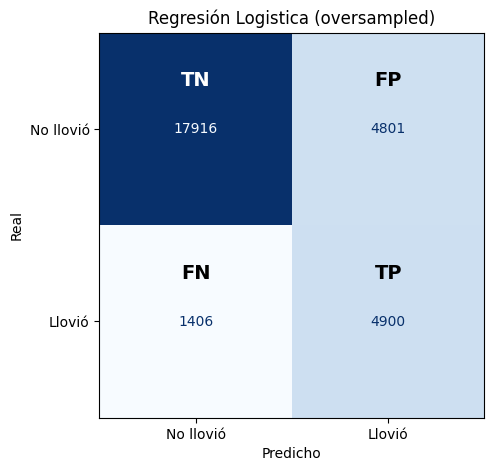

Resultados regresión logística oversampled:


Clase  Precision  Recall  F1-score  Accuracy
0      0      0.927   0.789     0.852     0.786
1      1      0.505   0.777     0.612     0.786

In [107]:
regresionLogistica_oversampled = LogisticRegression(random_state=42, max_iter=1000)
regresionLogistica_oversampled.fit(X_resampled, y_resampled)
y_pred_over = regresionLogistica_oversampled.predict(X_test)



graficar_matriz_confusion(y_test, y_pred_over, "Regresión Logistica (oversampled)")

# Metricas
accuracy = accuracy_score(y_test, y_pred_over)
precision = precision_score(y_test, y_pred_over, average=None)
recall = recall_score(y_test, y_pred_over, average=None)
f1 = f1_score(y_test, y_pred_over, average=None)
# Obtenemos los nombres de las clases
classes = sorted(list(set(y_test)))

# Creamos el DataFrame
resultados_oversampled = pd.DataFrame({
    'Clase': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1})

resultados_oversampled['Accuracy'] = accuracy

print("Resultados regresión logística oversampled:")
display(resultados_oversampled.round(3))



### Regresión utilizando SMOTE

In [108]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

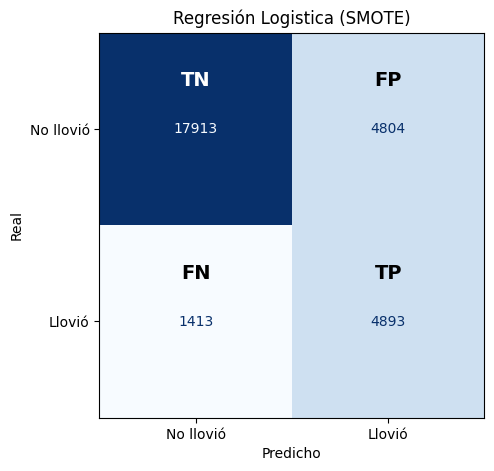

Resultados regresión logística con SMOTE:


Clase  Precision  Recall  F1-score  Accuracy
0      0      0.927   0.789     0.852     0.786
1      1      0.505   0.776     0.612     0.786

In [109]:
regresionLogistica_smote = LogisticRegression(random_state=42, max_iter=1000)
regresionLogistica_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = regresionLogistica_smote.predict(X_test)



graficar_matriz_confusion(y_test, y_pred_smote, "Regresión Logistica (SMOTE)")

# Metricas
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote, average=None)
recall = recall_score(y_test, y_pred_smote, average=None)
f1 = f1_score(y_test, y_pred_smote, average=None)
# Obtenemos los nombres de las clases
classes = sorted(list(set(y_test)))

# Creamos el DataFrame
resultados_smote = pd.DataFrame({
    'Clase': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1})

resultados_smote['Accuracy'] = accuracy

print("Resultados regresión logística con SMOTE:")
display(resultados_smote.round(3))

## Comparación de modelos

In [110]:
# Listamos las variables de los resultados a concatenar
dfs = [resultados_logistica, resultados_balanceada, resultados_oversampled, resultados_smote]

# Listamos sus nombres
model_names = ['Regresión Logistica', 'Regresión Logistica Balanceada', 'Regresión Logistica Oversampled', 'Regresión Logistica SMOTE']

combined_list = []

for df, name in zip(dfs, model_names):
    # Hacemos una copia para trabajar
    temp = df.copy()

    # Usamos .copy() para evitar un SettingWithCopyWarning
    temp_clase_1 = temp[temp['Clase'] == 1].copy()

    # Añadimos el nombre del modelo como una columna
    temp_clase_1['Modelo'] = name

    # Ya no usamos set_index. Simplemente añadimos el DF filtrado.
    combined_list.append(temp_clase_1)

# Concatenamos todos los DataFrames (cada uno tendrá una fila)
df_comparacion = pd.concat(combined_list)

# Seleccionamos/Reordenamos las columnas al formato deseado
#    (Esto también descarta la columna 'Clase' que ya no es necesaria)
columnas_finales = ['Modelo', 'Precision', 'Recall', 'F1-score', 'Accuracy']
df_comparacion = df_comparacion[columnas_finales]

# Reseteamos el índice para que sea 0, 1, 2, 3...
df_comparacion = df_comparacion.reset_index(drop=True)


print("Comparación de modelos (solo Clase 1)")
display(df_comparacion.round(3))

Comparación de modelos (solo Clase 1)


Modelo  Precision  Recall  F1-score  Accuracy
0              Regresión Logistica      0.710   0.487     0.578     0.845
1   Regresión Logistica Balanceada      0.505   0.777     0.612     0.786
2  Regresión Logistica Oversampled      0.505   0.777     0.612     0.786
3        Regresión Logistica SMOTE      0.505   0.776     0.612     0.786

## Curvas ROC

Reg. Logística: Mejor umbral (Youden) = 0.201
Reg. Logística balanced: Mejor umbral (Youden) = 0.480
Reg. Logística oversampled: Mejor umbral (Youden) = 0.476
Reg. Logística SMOTE: Mejor umbral (Youden) = 0.461


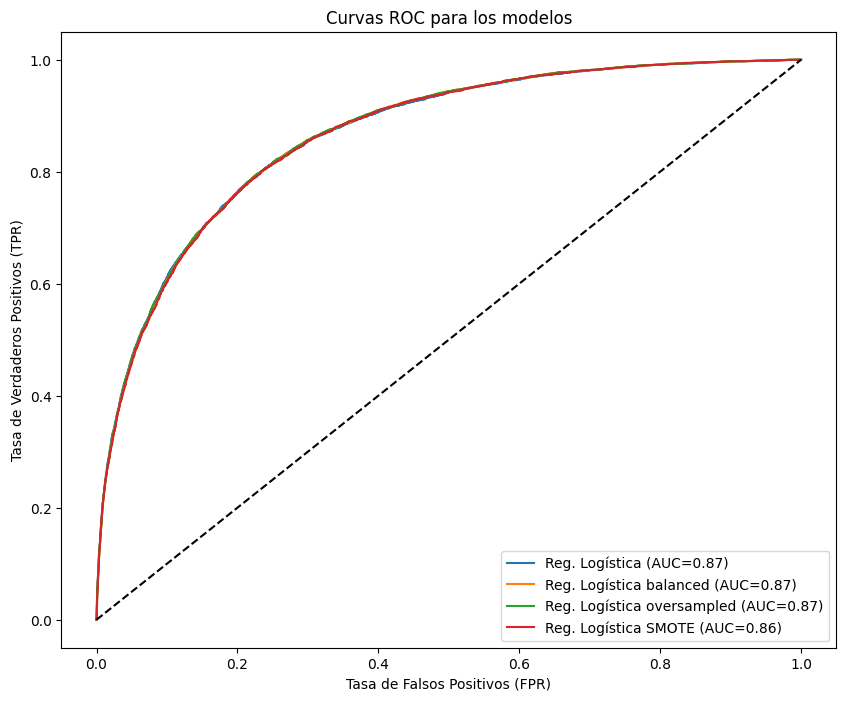

In [111]:
modelos = {
    "Reg. Logística": regresionLogistica,
    "Reg. Logística balanced": regresionLogistica_balanced,
    "Reg. Logística oversampled": regresionLogistica_oversampled,
    "Reg. Logística SMOTE": regresionLogistica_smote
}

plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    y_prob = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, lw=1.5, label=f'{nombre} (AUC={auc:.2f})')

    # calcular el mejor umbral según Youden
    youden_j = tpr - fpr
    idx = np.argmax(youden_j)
    best_thr = thresholds[idx]

    print(f"{nombre}: Mejor umbral (Youden) = {best_thr:.3f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para los modelos')
plt.legend()
plt.show()


Métricas con el nuevo umbral óptimo de Youden:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     22717
           1       0.49      0.79      0.61      6306

    accuracy                           0.78     29023
   macro avg       0.71      0.78      0.73     29023
weighted avg       0.84      0.78      0.79     29023



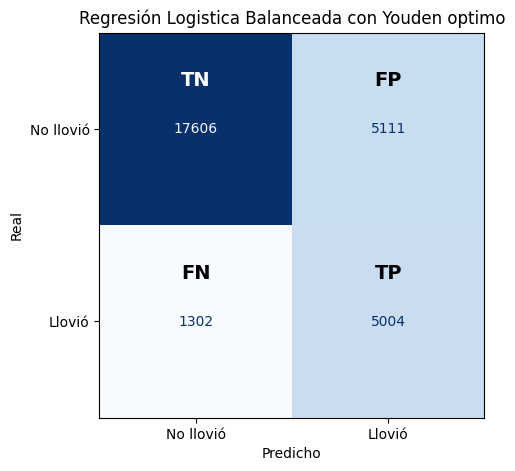

In [112]:
# Probamos el umbral obtenido para el modelo Regresión logistica balanceada

y_prob = regresionLogistica_balanced.predict_proba(X_test)[:, 1]

umbral_optimo_youden = 0.48

y_pred_youden = (y_prob >= umbral_optimo_youden).astype(int)


print("\nMétricas con el nuevo umbral óptimo de Youden:")
print(classification_report(y_test, y_pred_youden))


graficar_matriz_confusion(y_test, y_pred_youden, "Regresión Logistica Balanceada con Youden optimo")

In [113]:
# Agregamos el modelo con el youden optimo a nuestro df_comparacion

report_dict = classification_report(y_test, y_pred_youden, output_dict=True)

nombre_del_modelo = 'Regresión Logistica Balanceada con Youden optimo'
clase_objetivo = '1'

precision_c1 = report_dict[clase_objetivo]['precision']
recall_c1 = report_dict[clase_objetivo]['recall']
f1_c1 = report_dict[clase_objetivo]['f1-score']
accuracy_global = report_dict['accuracy']

resultados_youden = pd.DataFrame([{
    'Modelo': nombre_del_modelo,
    'Precision': precision_c1,
    'Recall': recall_c1,
    'F1-score': f1_c1,
    'Accuracy': accuracy_global
}])

df_comparacion = pd.concat([df_comparacion, resultados_youden], ignore_index=True)

df_comparacion

Modelo  Precision    Recall  \
0                               Regresión Logistica   0.710058  0.486997   
1                    Regresión Logistica Balanceada   0.504581  0.777355   
2                   Regresión Logistica Oversampled   0.505103  0.777038   
3                         Regresión Logistica SMOTE   0.504589  0.775928   
4  Regresión Logistica Balanceada con Youden optimo   0.494711  0.793530   

   F1-score  Accuracy  
0  0.577744  0.845330  
1  0.611947  0.785791  
2  0.612232  0.786135  
3  0.611510  0.785791  
4  0.609463  0.779037

# Modelo base

Para la creación del modelo base, tomamos como opción la de generar un modelo simple con únicamente dos de nuestras variables explicativas, las cuales son 'RainToday' (que expresa si ese día llovió) y 'min_max_diff' (que expresa la diferencia de temperatura que hubo en el dia entre la mínima y la máxima registrada).


Elegimos esas variables porque observamos que la variable 'RainToday' tiene una relación con la objetivo, ya que es frecuente que si un dia particular presentó lluvias, hay muchas posibilidades de que el día siguiente siga lloviendo, y la diferencia de temperatura la elegimos porque si en un dia hay mucha diferencia entre la máxima y la mínima, podría indicar que en el paso de una observación a otra las temperaturas variaron mucho lo que podría indicar que existieron lluvias.


In [114]:
X_train_base = X_train[['RainToday','min_max_diff']]
X_test_base = X_test[['RainToday', 'min_max_diff']]

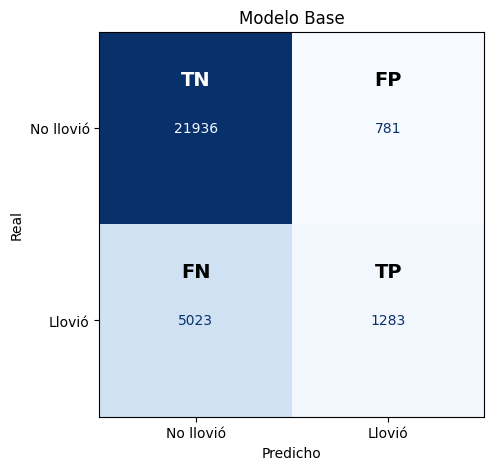

Resultados con modelo base:


Modelo  Clase  Precision  Recall  F1-score  Accuracy
0  Modelo Base      0      0.814   0.966     0.883       0.8
1  Modelo Base      1      0.622   0.203     0.307       0.8

/tmp/ipython-input-2150048812.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
modelo_base = LogisticRegression(random_state=42, max_iter=1000)
modelo_base.fit(X_train_base, y_train)
y_pred_base = modelo_base.predict(X_test_base)


graficar_matriz_confusion(y_test, y_pred_base, "Modelo Base")

# Metricas
accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base, average=None)
recall = recall_score(y_test, y_pred_base, average=None)
f1 = f1_score(y_test, y_pred_base, average=None)
# Obtenemos los nombres de las clases
classes = sorted(list(set(y_test)))

# Creamos el DataFrame
resultados_base = pd.DataFrame({
    'Modelo': 'Modelo Base',
    'Clase': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1})

resultados_base['Accuracy'] = accuracy

print("Resultados con modelo base:")
display(resultados_base.round(3))

# resultados_base solo clase 1
resultados_base_c1 = resultados_base[resultados_base['Clase'] == 1]
resultados_base_c1.drop(columns=['Clase'], inplace=True)
df_comparacion = pd.concat([df_comparacion,resultados_base_c1],ignore_index=True)

In [116]:
df_comparacion

Modelo  Precision    Recall  \
0                               Regresión Logistica   0.710058  0.486997   
1                    Regresión Logistica Balanceada   0.504581  0.777355   
2                   Regresión Logistica Oversampled   0.505103  0.777038   
3                         Regresión Logistica SMOTE   0.504589  0.775928   
4  Regresión Logistica Balanceada con Youden optimo   0.494711  0.793530   
5                                       Modelo Base   0.621609  0.203457   

   F1-score  Accuracy  
0  0.577744  0.845330  
1  0.611947  0.785791  
2  0.612232  0.786135  
3  0.611510  0.785791  
4  0.609463  0.779037  
5  0.306571  0.800021

Modelo base: Mejor umbral (Youden) = 0.232


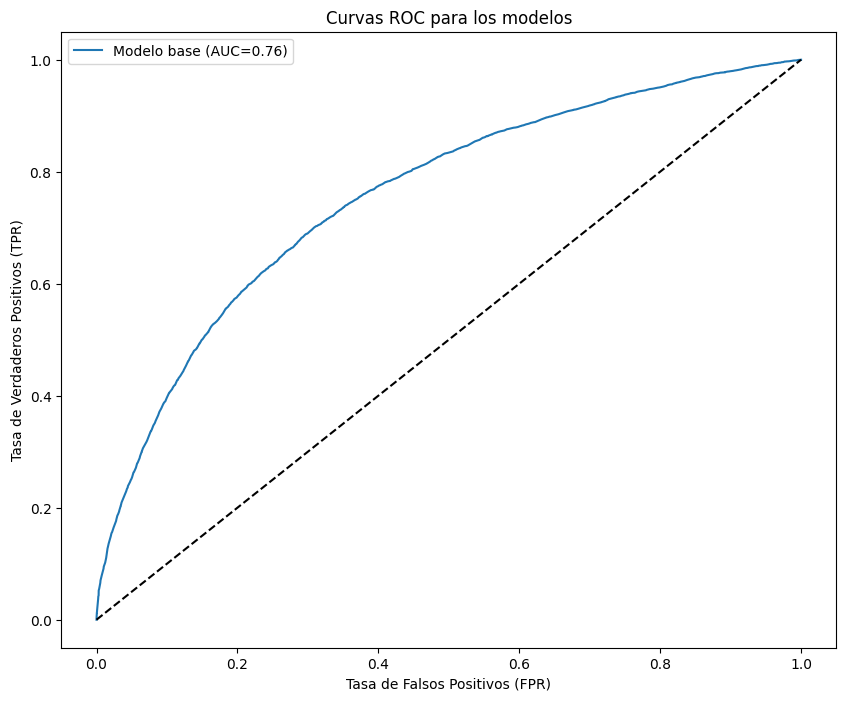

In [117]:
modelos = {
    "Modelo base": modelo_base,
}

plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    y_prob = modelo.predict_proba(X_test_base)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, lw=1.5, label=f'{nombre} (AUC={auc:.2f})')

    # calcular el mejor umbral según Youden
    youden_j = tpr - fpr
    idx = np.argmax(youden_j)
    best_thr = thresholds[idx]

    print(f"{nombre}: Mejor umbral (Youden) = {best_thr:.3f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para los modelos')
plt.legend()
plt.show()

Observamos que las métricas del modelo base son las esperadas para uno de esta baja complejidad, a priori si nos dejamos llevar por el 'accuracy' pareciera que el modelo es robusto, pero esta métrica se ve sesgada ya que el modelo es 'bueno' prediciendo aquellos días que no llovió y que forman parte de la clase mayoritaria, pero si miramos los verdaderos positivos detectamos que el modelo no es para nada eficaz prediciendo aquellos días que realmente llovió, por lo que su recall en esa clase como vemos es muy bajo.


Aun así teniendo todo esto en cuenta decimos que nuestro modelo base cumple el propósito por el cual fue creado, el cual es ser una referencia simple a la hora de nosotros proponer modelos más complejos y de esa manera mejorar esas métricas iniciales que nos servirán como punto de comparación.


# Optimización de parámetros


En este proyecto, se seleccionó RandomizedSearchCV como la estrategia de optimización de hiper parámetros por sobre GridSearchCV y Optuna, basándose en una decisión estratégica que prioriza la eficiencia computacional sin sacrificar significativamente la calidad de la optimización.


Realizamos múltiples pruebas variando los parámetros tanto en GridSearchCV como en Optuna y las conclusiones que sacamos se basan en que si bien sobre la teoría presentan una mejoría respecto de RandomSearchCv, el tiempo de ejecución de este último era drásticamente inferior al de los otros algoritmos, además de que el resultado en promedio de los mejores parámetros encontrados no era lo suficientemente superior a la búsqueda aleatoria, por lo que decidimos preservar el tiempo y la complejidad de ejecución por sobre una ínfima mejora del modelo.


RandomSearchCV representa el punto óptimo para este proyecto ofreciendo una exploración de hiperparametros suficiente dentro de un presupuesto computacional controlado, y manteniéndose nativo al ecosistema de scikit-learn que ya estábamos utilizando.





### RandomSearchCV

Dejamos comentada la funcion para optimizar los hiperparametros en nuestro modelo, la misma encontro los siguientes:
- C = 0.3149
- penalty = 'l1'
- solver = 'liblinear'

In [ ]:
def optimizar_hiperparametros(modelo):
  param_dist = {
      'C': loguniform(0.01, 100),
      # 'liblinear' soporta ambas penalizaciones
      'penalty': ['l1', 'l2'],
      'solver': ['liblinear']
  }


  f1_weighted_scorer = make_scorer(f1_score, average='weighted')


  random_search = RandomizedSearchCV(
      estimator=modelo,
      param_distributions=param_dist,
      n_iter=20,
      cv=5,
      scoring=f1_weighted_scorer,
      n_jobs=-1,
      verbose=2,
      random_state=42
  )

  random_search.fit(X_train, y_train)


  print(f"Mejor F1-Score (weighted) encontrado en CV: {random_search.best_score_:.4f}")
  print(random_search.best_params_)



  best_model_random = random_search.best_estimator_

  return best_model_random

regresionLogistica_balanced_optimizada = optimizar_hiperparametros(regresionLogistica_balanced)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor F1-Score (weighted) encontrado en CV: 0.7845
{'C': 0.010071984838809197, 'penalty': 'l2', 'solver': 'liblinear'}


              precision    recall  f1-score   support

           0       0.93      0.79      0.85     22717
           1       0.50      0.78      0.61      6306

    accuracy                           0.79     29023
   macro avg       0.72      0.78      0.73     29023
weighted avg       0.84      0.79      0.80     29023



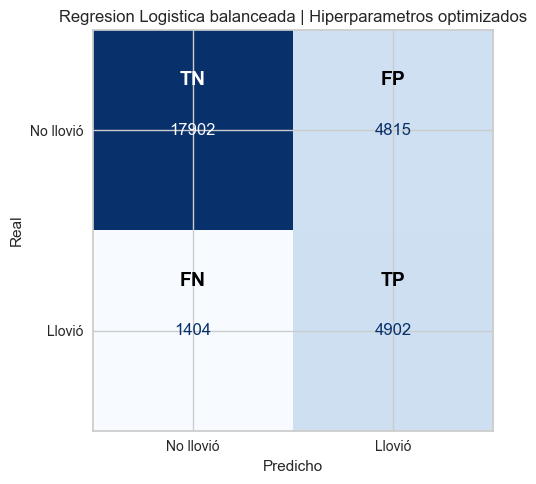

In [ ]:
regresionLogistica_balanced_optimizada = LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced',C=0.3149,penalty='l1',solver='liblinear')
regresionLogistica_balanced_optimizada.fit(X_train, y_train)
y_pred_optimizada = regresionLogistica_balanced_optimizada.predict(X_test)

print(classification_report(y_test, y_pred_optimizada))

graficar_matriz_confusion(y_test, y_pred_optimizada,'Regresión Logistica balanceada | Hiperparametros optimizados')



In [ ]:
accuracy = accuracy_score(y_test, y_pred_optimizada)

clase = [1]

# Usamos labels=clase para calcular métricas solo para esa clase
precision = precision_score(y_test, y_pred_optimizada, average=None, labels=clase)
recall = recall_score(y_test, y_pred_optimizada, average=None, labels=clase)
f1 = f1_score(y_test, y_pred_optimizada, average=None, labels=clase)

# Creamos el DataFrame directamente con los datos de la clase 1
report_dict_rls = pd.DataFrame({
    'Modelo': 'Regresión Logistica balanceada | Hiperparametros optimizados',
    'Clase': clase,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

report_dict_rls['Accuracy'] = accuracy

display(report_dict_rls.round(3))

Modelo  Clase  Precision  \
0  Regresion Logistica balanceada | Hiperparametr...      1      0.504   

   Recall  F1-score  Accuracy  
0   0.777     0.612     0.786

In [ ]:
# guardar resultados en df_comparacion
report_dict_rls_c1 = report_dict_rls[report_dict_rls['Clase'] == 1]
report_dict_rls_c1.drop(columns=['Clase'], inplace=True)
df_comparacion = pd.concat([df_comparacion,report_dict_rls_c1],ignore_index=True)

In [ ]:
df_comparacion

Modelo  Precision    Recall  \
0                                Regresion Logistica   0.709961  0.487155   
1                     Regresion Logistica Balanceada   0.504581  0.777196   
2                    Regresion Logistica Oversampled   0.505063  0.775135   
3                          Regresion Logistica SMOTE   0.503867  0.774818   
4   Regresion Logistica Balanceada con Youden optimo   0.494612  0.793371   
5                                        Modelo Base   0.621609  0.203457   
6  Regresion Logistica balanceada | Hiperparametr...   0.504477  0.777355   

   F1-score  Accuracy  
0  0.577824  0.845330  
1  0.611898  0.785791  
2  0.611612  0.786101  
3  0.610636  0.785308  
4  0.609342  0.778968  
5  0.306571  0.800021  
6  0.611870  0.785722

# Explicabilidad de modelos

Para esta etapa debemos centrarnos en cuáles son las características más significativas para el modelo a la hora de predecir nuestra variable objetivo, es por ello que para saber qué características aportan más que otras utilizamos la librería SHAP.

SHAP (SHapley Additive exPlanations) es un método para explicar las predicciones de un modelo. Se basa en la teoría de juegos de Shapley y mide cuánto aporta cada variable (feature) a la predicción de una observación.

En términos simples: los SHAP values explican por qué el modelo tomó una determinada decisión para una observación puntual.

In [ ]:
import shap
shap.initjs()

In [ ]:
# Crea un objeto explainer SHAP

# Obtenemos las columnas de train
feature_names = X_train.columns

# Instanciamos el objeto LinearExplainer con nuestro modelo, los valores de train y los nombres de las columnas
explainer = shap.LinearExplainer(regresionLogistica_balanced, X_train, feature_names=feature_names)

# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test)

### Explicabilidad local

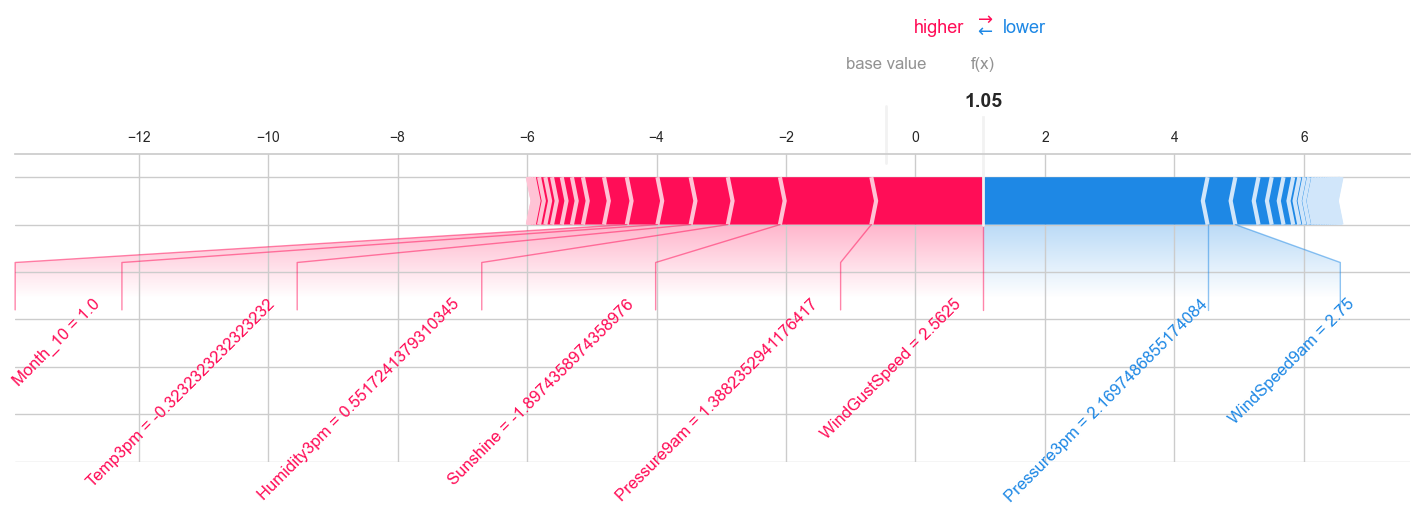

In [ ]:
index = 0

# Al aclararle sobre que indice queremos conocer o graficar los valores podemos observar la explicabilidad local
shap.force_plot(explainer.expected_value, shap_values[index],
                X_test.iloc[index], feature_names=feature_names,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

En este caso, para el primer elemento de nuestro conjunto, el valor base que presenta es el que el modelo predice antes de ver ninguna variable de observación, en este caso es -0.307. A partir de esa inicialización podemos ver el aporte que hace cada variable para subir o bajar el resultado final de esa predicción, destacando las que más aportan positivamente la velocidad del viento y la presión a las 9am ('WindGustSpeed' y 'Pressure9am'). En cambio las que más aportan negativamente a esa predicción de lluvia son la presión a las 3pm y en menor medida la velocidad del viento a las 9 am ('WindGustSpeed' y 'Pressure3pm').


Una vez realizado todo ese cálculo para esa observación en particular, el valor final que resulta es 1.05, es decir una predicción positiva (llovió).


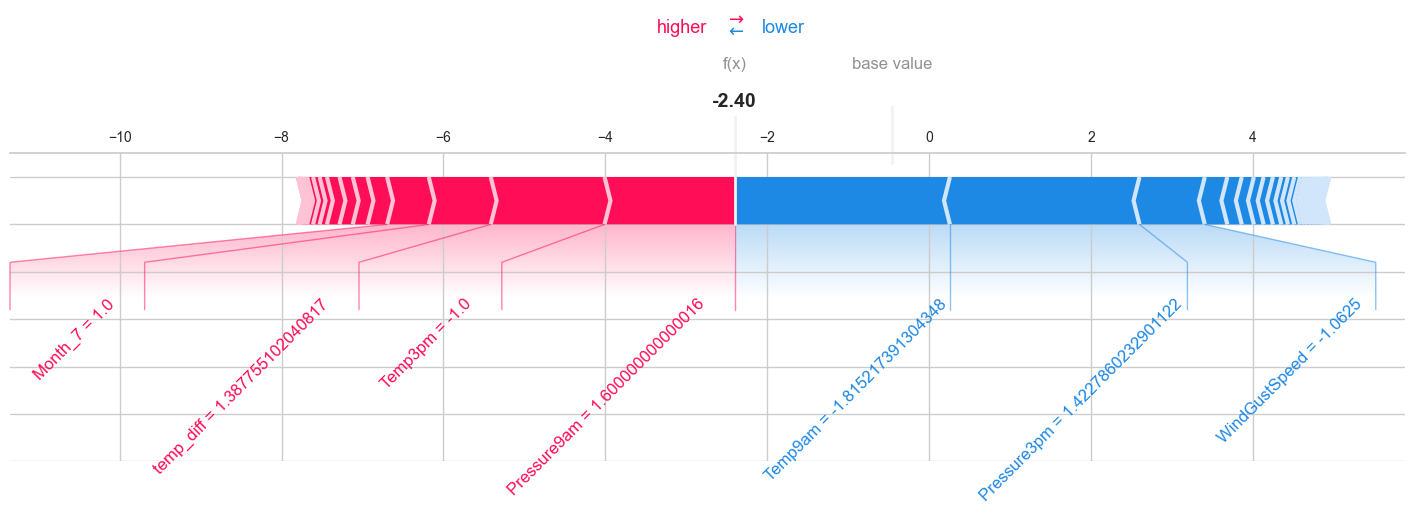

In [ ]:
index = 3

# Al aclararle sobre que indice queremos conocer o graficar los valores podemos observar la explicabilidad local
shap.force_plot(explainer.expected_value, shap_values[index],
                X_test.iloc[index], feature_names=feature_names,
                matplotlib=True, figsize=(18, 4), text_rotation=45)

Para este otro gráfico de fuerzas podemos ver que se trata de una predicción final negativa, es decir no llovió.


Podemos ver que las variables que más influencia tuvieron cambiaron ya que seguimos analizando de forma local la influencia de las mismas, en este caso la presión de las 9am y la temperatura de las 3pm ('Pressure9am' y 'Temp3pm') son las que más influyeron positivamente, en contraparte las que terminaron ganando esta pulseada fueron las de influencia negativa que resultaron en un valor final de -2.4, entre las más influyentes están la temperatura a las 9am y la presión a las 3pm ('Temp9am' y 'Pressure3pm'), destacar que para esta predicción negativa las variables más influyentes tanto positiva como negativamente pertenecen a los mismos grupos pero de horarios análogos de observación.



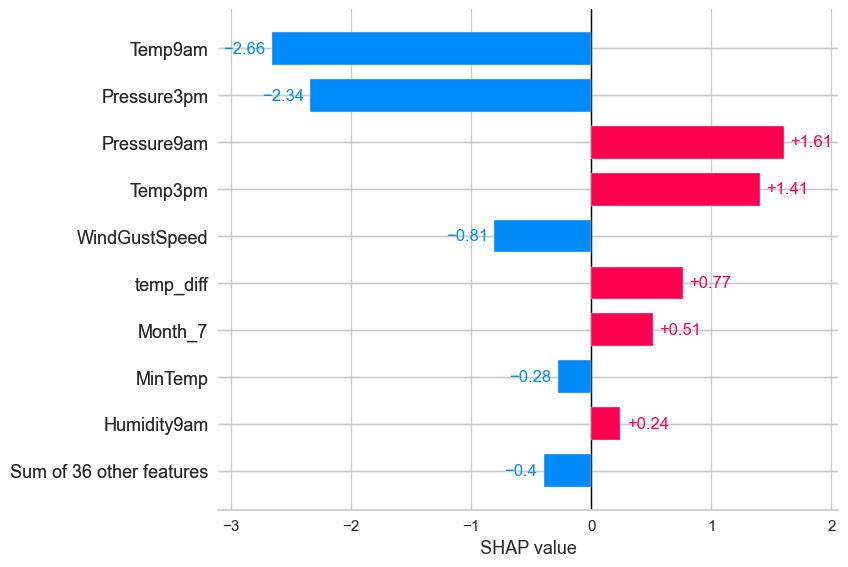

In [ ]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)

shap.plots.bar(explanation)

En este gráfico de barras podemos ver la misma explicación local de los valores pero de forma más intuitiva, esto nos sirve para saber como es el peso específico de las principales variables a la hora de predecir el valor final de la variable de una manera más visual.



### Explicabilidad Global

A diferencia de la explicabilidad local, la global indica cómo actúan todas las variables del dataset en promedio a la hora de realizar las predicciones, es por eso que realizamos dos gráficos para visualizar la influencia de las features,el primero un gráfico de barras horizontales y luego un gráfico 'beeswarm'.

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)

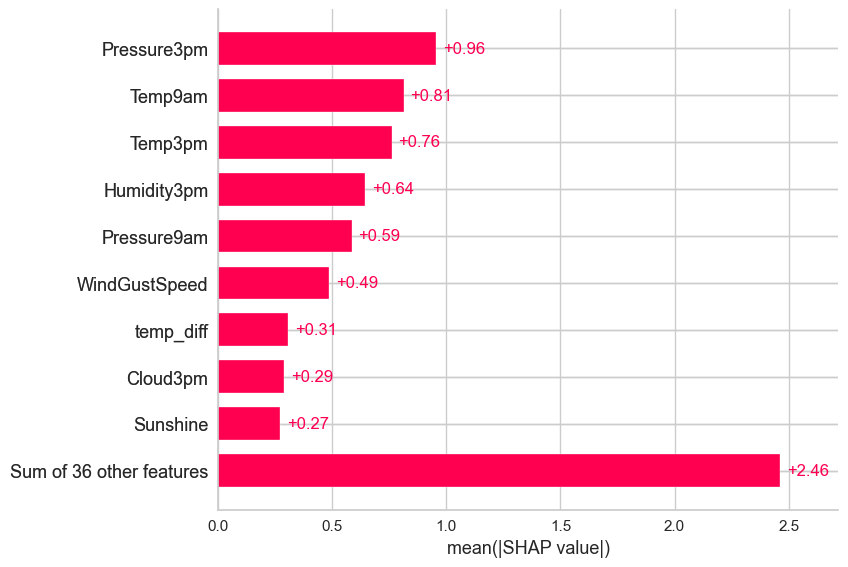

In [ ]:
shap.plots.bar(explanation)

En este primero podemos ver en el eje 'y' las features ordenadas de mayor a menor importancia a la hora de realizar las predicciones, presentando sus valores absolutos por lo que no podemos indicar inicialmente si influyen de forma negativa o positiva, pero vemos que las más pesadas son las presiones en sus dos observaciones diarias, la temperatura también en sus dos registros y luego la humedad a las 3pm entre las principales, también podemos ver que aunque hay 5 features estrella, el modelo utiliza la suma de muchas otras variables (36) con pequeños impactos para afinar su decisión. No es un modelo simple que solo mira dos o tres características.


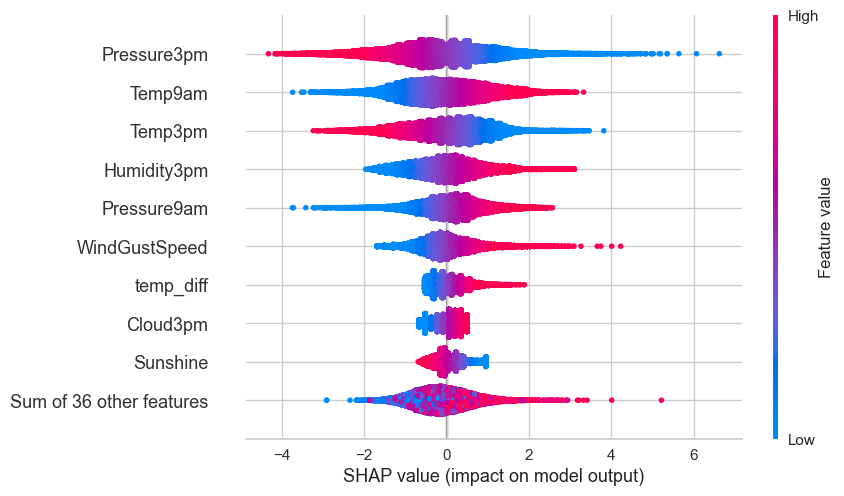

In [ ]:
shap.plots.beeswarm(explanation)

Este gráfico de resumen SHAP nos ofrece la visión más completa de la lógica interna de nuestro modelo. Es la herramienta más densa de nuestro análisis, ya que cada punto en el gráfico representa una predicción individual, permitiéndonos ver los patrones globales que el modelo ha aprendido.

Más allá de confirmar la jerarquía de importancia que ya conocíamos (con Pressure3pm en la cima), este gráfico nos revela el "cómo". El eje horizontal nos muestra el impacto en la predicción, donde los valores positivos empujan hacia "Llovió" (Clase 1) y los negativos hacia "No Llovió" (Clase 0). El color de cada punto nos dice si el valor de esa feature era alto (rojo) o bajo (azul) para esa predicción.

Al leerlo, es evidente que el modelo no está adivinando, sino que ha aprendido una lógica meteorológica muy coherente.

La división en Pressure3pm es la más clara: casi todos los puntos rojos (alta presión) se agrupan en el lado izquierdo, empujando la predicción fuertemente hacia "No Llovió", mientras que la baja presión (azul) la empuja hacia "Llovió". Vemos esta misma correspondencia directa en Humidity3pm, donde la alta humedad (rojo) es uno de los predictores más fuertes de "Lluvia".

De forma inversa el modelo aprendió que muchas horas de Sunshine (rojo) son un indicador claro de "No Llovió". Curiosamente, el modelo también asocia las temperaturas más altas, tanto Temp9am como Temp3pm, con una mayor probabilidad de lluvia, lo cual tiene sentido al capturar el patrón de las tormentas que ocurren en días calurosos.

En definitiva, este gráfico nos da la confianza de que nuestro modelo no es una "caja negra". Ha aprendido un conjunto de reglas defendibles y meteorológicamente sólidas, basando sus predicciones en la combinación de baja presión, alta humedad y altas temperaturas.

# AutoML


En esta etapa nos disponemos a implementar un modelo de Auto Machine Learning de la librería Pycaret, para ver como performa en comparación a nuestras implementaciones esta aplicación, la cual puede ser muy útil para tener un primer vistazo de qué alternativas u opciones podemos considerar a la hora de desarrollar nuestro propio modelado.


In [ ]:
# from pycaret.classification import *

Volvemos a llamar a nuestro dataset original, le eliminamos aquellos registros donde la variable objetivo no existe y le realizamos una división en train y test de las features iniciales.



In [ ]:
# df = pd.read_csv('weatherAUS.csv')

# df = df.dropna(subset=["RainTomorrow"])

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


En la celda siguiente instanciamos al modelo con nuestros datos de entrenamiento, le informamos cuál es la variable que debe predecir, además de parámetros adicionales como la forma a imputar las columnas numéricas.



In [ ]:
# s = setup(data=train_df, target='RainTomorrow', train_size=0.8, session_id=42,  numeric_imputation="median", fix_imbalance=True)

Esta es la etapa que lleva un poco más de tiempo y es donde el modelo comienza a comparar uno a uno sus alternativas y termina eligiendo a la ganadora, en este caso elige el modelo 'Extra Trees Classifier'.



In [ ]:
# best_model = compare_models()
# print(best_model)

Una vez obtenido el mejor de los modelos, hacemos las predicciones en base a él y visualizamos el dataframe resultante que creó de forma automática para llevar a cabo el análisis.



In [ ]:
# # Realizamos predicciones sobre los datos de prueba
# predictions = predict_model(best_model, data=test_df)
# predictions.head()

In [ ]:
# predictions.columns

In [ ]:
# y_true = predictions['RainTomorrow']
# y_pred_pycaret = predictions['prediction_label']

# accuracy = accuracy_score(y_true, y_pred_pycaret)
# precision = precision_score(y_true, y_pred_pycaret, pos_label='Yes')
# recall = recall_score(y_true, y_pred_pycaret, pos_label='Yes')
# f1 = f1_score(y_true, y_pred_pycaret, pos_label='Yes')

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)


In [ ]:
# graficar_matriz_confusion(y_true,y_pred_pycaret,'Mejor modelo Pycaret')

Una vez entrenado y habiendo hecho las predicciones, podemos ver las métricas y la matriz de confusión del modelo automático, y podemos comprobar que en general presenta métricas similares a algunos de los modelos construidos por nosotros, pero en lo que respecta a la capacidad de predecir cuando efectivamente llueve, tiene de las métricas más bajas de toda la comparativa, por lo que nuevamente podemos afirmar que si bien es un buen puntapié inicial para tomar algunas decisiones o criterios, no reemplaza toda la complejidad y análisis de relaciones o detalles existentes variables que podríamos realizar por nuestra cuenta con el previo conocimiento del área sobre la que estamos trabajando.



In [ ]:
# # creamos un df con los resultados
# report_dict_pycaret = pd.DataFrame({
#     'Modelo': 'Mejor modelo Pycaret',
#     'Precision': [precision],
#     'Recall': [recall],
#     'F1-score': [f1],
#     'Accuracy': [accuracy]})

# # concatenar a df_comparacion
# df_comparacion = pd.concat([df_comparacion, report_dict_pycaret], ignore_index=True)

In [ ]:
# df_comparacion

# Redes neuronales

En esta

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.simplefilter('ignore')

In [ ]:
X_train.shape

In [ ]:
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        #inicializo algunos parámetros como épocas, batch_size, learning rate
        #(no son necesarios)
        #se puede agregar la cantidad de capas, la cantidad de neuronas por capa (pensando en hacer una clase que pueda ser usada para cualquier caso)
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape):
        # ejemplo con 2 capas ocultas de 64 neuronas y activación softmax (multiclase, recibe la cantidad de clases como input, además del input_shape)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(45, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        #compilo el modelo con el optimizador Adam, la función de pérdida categorical_crossentropy y la métrica f1 score
        #totalmente optimizable e incluso pueden ser parámetros de la función build_model

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        metrica_f1 = tf.keras.metrics.F1Score(threshold=0.5, average='weighted', name='f1_score')
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrica_f1])

        self.model = model
        model.summary()

    def train(self, X_train, y_train, X_valid, y_valid):
        early_stopping = EarlyStopping(
            monitor='val_f1_score',
            patience=15,
            restore_best_weights=True)

        # simplemente el fit del modelo. Devuelvo la evolución de la función de pérdida, ya que es interesante ver como varía a medida que aumentan las épocas!
        history=self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=self.epochs, batch_size=self.batch_size, callbacks=[early_stopping])
        return history.history['loss'], history.history['val_f1_score']

    def evaluate(self, X_test, y_test):
        ### evalúo en test
        loss, f1 = self.model.evaluate(X_test, y_test)
        print(f"test F1-Score: {f1:.4f}")

    def predict(self, X_new):
        ### predicciones
        predictions = self.model.predict(X_new)
        return predictions


    ### acá también me podría armar una función para graficar la evolución de la función de pérdida en train y validación, etc etc

In [ ]:
## Probar Balancear con smote solamente train

## Optimizacion

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 1. Preparar datos (Train y Validation para Optuna)
# Asumimos que X_train_full e y_train_full son tus datos de entrenamiento originales
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

def objective(trial):
    # --- A. Sugerir Hiperparámetros ---
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    batch = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    eps = trial.suggest_int('epochs', 30, 100) # Rango sugerido

    # --- B. Instanciar TU clase ---
    nn = NeuralNetwork(epochs=eps, batch_size=batch, learning_rate=lr)

    # --- C. Construir y Entrenar ---
    # Nota: Tu método train ahora maneja el build_model internamente o lo llamamos antes
    nn.build_model(X_train_opt.shape[1])

    # Entrenamos pasando el set de validación
    nn.train(X_train_opt, y_train_opt, X_val_opt, y_val_opt)

    # --- D. Evaluar (Métrica objetivo: F1 Score) ---
    # 1. Predecir probabilidades
    probs = nn.predict(X_val_opt)

    # 2. Convertir probabilidad a clase binaria (0 o 1) usando umbral 0.5
    preds_binarios = (probs > 0.5).astype(int)

    # 3. Calcular F1 usando Scikit-Learn (más fiable para el score final)
    score = f1_score(y_val_opt, preds_binarios)

    return score

# --- Ejecutar Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15) # 15 pruebas

print("¡Mejores parámetros encontrados!")
print(study.best_params)
print("Mejor F1 Score:", study.best_value)

In [ ]:
nn = NeuralNetwork(epochs=93, batch_size=16, learning_rate=0.0019)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#buildeo el modelo
nn.build_model(input_shape=X_train.shape[1])

# entreno el modelo
history=nn.train(X_train, y_train, X_valid, y_valid)



In [ ]:
# evaluo metricas
nn.evaluate(X_test, y_test)

In [ ]:
# evaluo metricas train
nn.evaluate(X_train, y_train)

# Explicabilidad

## Local

In [ ]:
# Indice a graficar
idx = 0

# A. Limpiar Base Value (Valor esperado)
# A veces es una lista o un tensor. Queremos un SOLO numero float.
base_val = explainer.expected_value
if isinstance(base_val, list):
    base_val = base_val[0]
if hasattr(base_val, 'numpy'):
    base_val = base_val.numpy()

# Aseguramos que sea un float escalar
base_val = float(base_val)


# B. Limpiar SHAP Values
# DeepExplainer devuelve una lista [matriz]. Accedemos a la lista [0] y luego a la fila [idx].
if isinstance(shap_values, list):
    raw_shap = shap_values[0][idx]
else:
    raw_shap = shap_values[idx]

# Forzamos a que sea un array plano de 1 dimensión
shap_val_clean = np.array(raw_shap).flatten()


# C. Limpiar los Datos Reales (Feature values)
# Forzamos también a que sea plano
data_val_clean = X_test.iloc[idx].values.flatten()


shap.force_plot(
    base_val,
    shap_val_clean,
    data_val_clean,
    feature_names=feature_names,
    matplotlib=True,
    figsize=(20, 3),
    text_rotation=45
)

In [ ]:
# Indice a graficar
idx = 3

# A. Limpiar Base Value (Valor esperado)
# A veces es una lista o un tensor. Queremos un SOLO numero float.
base_val = explainer.expected_value
if isinstance(base_val, list):
    base_val = base_val[0]
if hasattr(base_val, 'numpy'):
    base_val = base_val.numpy()

# Aseguramos que sea un float escalar
base_val = float(base_val)


# B. Limpiar SHAP Values
# DeepExplainer devuelve una lista [matriz]. Accedemos a la lista [0] y luego a la fila [idx].
if isinstance(shap_values, list):
    raw_shap = shap_values[0][idx]
else:
    raw_shap = shap_values[idx]

# Forzamos a que sea un array plano de 1 dimensión
shap_val_clean = np.array(raw_shap).flatten()


# C. Limpiar los Datos Reales (Feature values)
# Forzamos también a que sea plano
data_val_clean = X_test.iloc[idx].values.flatten()


shap.force_plot(
    base_val,
    shap_val_clean,
    data_val_clean,
    feature_names=feature_names,
    matplotlib=True,
    figsize=(20, 3),
    text_rotation=45
)

In [ ]:
# Indice de la observación que quieres explicar
index = 0


# A. Valores SHAP:
# Si es una lista (Keras), sacamos el [0]. Luego sacamos la fila [index].
raw_val = shap_values[0][index] if isinstance(shap_values, list) else shap_values[index]
# El paso mágico: .flatten() convierte [[0.1, ...]] en [0.1, ...]
shap_val_clean = np.array(raw_val).flatten()

# B. Datos Reales (Data):
# También aplanamos para evitar errores de pandas
data_clean = X_test.iloc[index].values.flatten()

# C. Base Value:
# Aseguramos que sea un float simple de Python
base_val_clean = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value
if hasattr(base_val_clean, 'numpy'):
    base_val_clean = base_val_clean.numpy()
base_val_clean = float(base_val_clean)



# CREAR EXPLANATION
explanation = shap.Explanation(
    values=shap_val_clean,
    base_values=base_val_clean,
    data=data_clean,
    feature_names=feature_names)


shap.plots.bar(explanation)

## Global

In [ ]:
# Extraemos de la lista y quitamos dimensiones sobrantes (N, 45, 1) -> (N, 45)
vals = shap_values[0] if isinstance(shap_values, list) else shap_values
vals = np.squeeze(vals)

# Obtenemos el número puro
base_scalar = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value
if hasattr(base_scalar, 'numpy'):
    base_scalar = base_scalar.numpy()
base_scalar = float(base_scalar)


if vals.ndim == 2:
    # Caso Global (varias filas): Repetimos el valor N veces
    base_values_array = np.repeat(base_scalar, vals.shape[0])
else:
    # Caso Local (1 fila): Lo dejamos como array escalar
    base_values_array = np.array(base_scalar)


# Aseguramos que data sea numpy puro
# data_vals = X_test_sample.values
data_vals = X_test.values



explanation = shap.Explanation(
    values=vals,
    base_values=base_values_array,
    data=data_vals,
    feature_names=feature_names)


shap.plots.bar(explanation, max_display=15)

In [ ]:
# --- PASO 1: DEFINIR LA MUESTRA ÚNICA (La fuente de la verdad) ---
# Usaremos 20 filas para que el beeswarm tenga suficientes puntos
n_samples = 20
X_sample = X_test.iloc[:n_samples]

# --- PASO 2: CALCULAR SHAP VALUES PARA ESA MUESTRA ---
# Es vital calcularlos SOBRE X_sample, no sobre X_test entero ni otra variable
shap_values_raw = explainer.shap_values(X_sample.values)

# --- PASO 3: LIMPIEZA Y FORMATO ---

# A. Limpiar SHAP Values (Squeeze para quitar dimensiones extra)
vals = shap_values_raw[0] if isinstance(shap_values_raw, list) else shap_values_raw
vals = np.squeeze(vals) # Debe quedar (20, 45)

# B. Limpiar Base Value (Repetirlo 20 veces)
base_scalar = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value
if hasattr(base_scalar, 'numpy'):
    base_scalar = base_scalar.numpy()

# Creamos un array de 20 elementos iguales
base_values_array = np.repeat(float(base_scalar), n_samples)

# --- PASO 4: CREAR EL OBJETO EXPLANATION ---
explanation = shap.Explanation(
    values=vals,
    base_values=base_values_array,
    data=X_sample.values,  # <--- COINCIDE EXACTAMENTE CON EL TAMAÑO DE VALS
    feature_names=feature_names
)

# --- PASO 5: GRAFICAR ---
print(f"Dimensiones Values: {explanation.values.shape}")
print(f"Dimensiones Data: {explanation.data.shape}")
# Si ambos dicen (20, 45), el gráfico funcionará.

shap.plots.beeswarm(explanation, max_display=15)

# ML OPS

In [ ]:
# --- PASO PREVIO DE REPARACIÓN ---
# Creamos una copia para no romper nada más
export_train = train.copy()

# 1. Recuperar 'Month' desde 'Date' (si Date existe)
if 'Month' not in export_train.columns and 'Date' in export_train.columns:
    export_train['Month'] = export_train['Date'].dt.month

# 2. Recuperar 'RegionCluster'
# Como lo borramos al hacer OneHotEncoding, lo recalculamos usando el kmeans que ya tienes en memoria
if 'RegionCluster' not in export_train.columns:
    # Aseguramos que existan Lat/Lon (llenando con 0 si hubiera nulos raros, solo para este cálculo)
    coords_temp = export_train[['Latitud', 'Longitud']].fillna(0)
    export_train['RegionCluster'] = kmeans.predict(coords_temp)

    # Corrección manual de Norfolk si aplica (como hiciste en el análisis)
    if 'Location' in export_train.columns:
        export_train.loc[export_train['Location'] == 'NorfolkIsland', 'RegionCluster'] = 5

# --- AHORA SÍ, TU LÓGICA DE EXPORTACIÓN ---

# 1. Calcular Tablas de Búsqueda (Lookup Tables)
cols_loc_month = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm',
                  'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm']

# Usamos export_train que ya tiene las columnas arregladas
lookup_loc_month = export_train.groupby(['Location', 'Month'])[cols_loc_month].median().reset_index()

cols_cluster_month = ['Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Evaporation', 'Sunshine']
lookup_cluster_month = export_train.groupby(['RegionCluster', 'Month'])[cols_cluster_month].median().reset_index()

# Modas por Cluster
cols_cat_impute = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
lookup_cluster_modes = export_train.groupby('RegionCluster')[cols_cat_impute].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
).reset_index()

# 2. Calcular Ratios (Usamos export_train)
ratios = {
    'humidity_3pm_to_9am': (export_train['Humidity3pm'] / export_train['Humidity9am']).median(),
    'humidity_9am_to_3pm': (export_train['Humidity9am'] / export_train['Humidity3pm']).median(),
    'min_to_max': (export_train['MinTemp'] / export_train['MaxTemp']).median(),
    'max_to_min': (export_train['MaxTemp'] / export_train['MinTemp']).median(),
    'temp_9am_to_3pm': (export_train['Temp9am'] / export_train['Temp3pm']).median(),
    'temp_3pm_to_9am': (export_train['Temp3pm'] / export_train['Temp9am']).median(),
    'pressure_9am_to_3pm': (export_train['Pressure9am'] / export_train['Pressure3pm']).median(),
    'pressure_3pm_to_9am': (export_train['Pressure3pm'] / export_train['Pressure9am']).median(),
    'cloud_9am_to_3pm': (export_train['Cloud9am'] / export_train['Cloud3pm']).median(),
    'cloud_3pm_to_9am': (export_train['Cloud3pm'] / export_train['Cloud9am']).median(),
}

# Nota: Asegúrate que 'cols_numericas' esté definida en tu notebook, si no, defínela aquí
# Si no la tienes a mano, usa esto:
cols_numericas_fallback = cols_loc_month + cols_cluster_month # Unimos las listas numéricas

# 3. Empaquetar todo
exact_artifacts = {
    'lookups': {
        'loc_month': lookup_loc_month,
        'cluster_month': lookup_cluster_month,
        'cluster_modes': lookup_cluster_modes
    },
    'ratios': ratios,
    # Usamos export_train para calcular las medianas globales
    'global_medians': export_train[cols_numericas_fallback].median().to_dict(),
    'wind_dir_map': wind_dir_map
}

# 4. Guardar
# Asegúrate que la carpeta 'docker' exista
import os
if not os.path.exists('docker'):
    os.makedirs('docker')

joblib.dump(exact_artifacts, 'docker/artifacts_exact.joblib')
joblib.dump(kmeans, 'docker/kmeans.joblib')
joblib.dump(encoder, 'docker/encoder.joblib')
joblib.dump(scaler, 'docker/scaler.joblib')

# Guardado de la Red Neuronal (asumiendo que tu objeto se llama 'nn')
nn.model.save('docker/model_nn.keras')

print("¡Artefactos EXACTOS guardados correctamente en la carpeta docker!")